### Import required libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.api.tsa import VARMAX

In [2]:
from datetime import datetime

start_time = datetime.now()

### Read and joining the data files

In [3]:
data_store = pd.read_csv("Dataset/store.csv")
data_store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [4]:
data_train = pd.read_csv("Dataset/train.csv", parse_dates=['Date'])
data_train.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
# We join the 2 data sources on "Store" column

data_merged = pd.merge(left=data_train, right=data_store, how='left', left_on='Store', right_on='Store')
print(f"Merged data: {data_merged.shape}")
data_merged.head()

Merged data: (1017209, 18)


Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

### Keeping data for limited stores

In [6]:
# Keeping only the 9 stores mentioned in the problem statement

list_stores = [1, 3, 8, 9, 13, 25, 29, 31, 46]    # list of 9 targeted store Ids
len_stores = len(list_stores)

In [7]:
# filter the data only for targeted store Ids
data_final = data_merged[data_merged['Store'].isin(list_stores)]
data_final.sort_values(by=['Store','Date'], ascending=True, axis=0, inplace=True)

print(data_final.shape)
data_final.head()

(8110, 18)


Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
1016095      1          2 2013-01-01      0          0     0      0   
1014980      1          3 2013-01-02   5530        668     1      0   
1013865      1          4 2013-01-03   4327        578     1      0   
1012750      1          5 2013-01-04   4486        619     1      0   
1011635      1          6 2013-01-05   4997        635     1      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
1016095            a              1         c          a               1270.0   
1014980            0              1         c          a               1270.0   
1013865            0              1         c          a               1270.0   
1012750            0              1         c          a               1270.0   
1011635            0              1         c          a               1270.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1016095                        9.0                    2008.0       0   
1014980                        9.0                    2008.0       0   
1013865                        9.0                    2008.0       0   
1012750                        9.0                    2008.0       0   
1011635                        9.0                    2008.0       0   

         Promo2SinceWeek  Promo2SinceYear PromoInterval  
1016095              NaN              NaN           NaN  
1014980              NaN              NaN           NaN  
1013865              NaN              NaN           NaN  
1012750              NaN              NaN           NaN  
1011635              NaN              NaN           NaN

### Defining important functions

In [8]:
def normalize(series, val_min, val_max):
    norm_series = (series - val_min)/(val_max - val_min)
    return norm_series

def denormalize(series, val_min, val_max):
    denorm_series = ((val_max - val_min) * series) + val_min
    return denorm_series

def prevDataReplace(data,startdate,enddate,store,column):
    for index, row in data.iterrows():
        if ((pd.isna(row[column]) and (index.strftime("%Y-%m-%d") >= startdate) and (index.strftime("%Y-%m-%d") <= enddate))):
            date=pd.to_datetime(index)
            previousYearDate=date- relativedelta(years=1)
            previousYearDate= previousYearDate.strftime("%Y-%m-%d")
            previousYearData=data[data.index==previousYearDate][column]
            data.loc[index.strftime("%Y-%m-%d"), column]=previousYearData.get(previousYearDate)

def rmse_mape(test_actual, test_predicted):
    rmse = np.sqrt(mean_squared_error(test_actual, test_predicted)).round(2)
    mape = np.round(np.mean(np.abs(test_actual-test_predicted)/test_actual)*100,2)
   
    return rmse, mape

def checkStationarity(varname):
    adf_test = adfuller(varname)
    pvalue = adf_test[1]
    adf_flag = pvalue < 0.06 # non-stationary criteria
    exp = ""

    if adf_flag:
        adf_res = "Stationary"
    else:
        adf_res = "Non-stationary"
    
    return adf_res

def checkCointegration(series1, series2):
    delta_series = series1 - series2
    
    adf_test = adfuller(delta_series)
    pvalue = adf_test[1]
    adf_flag = pvalue < 0.05 #non-stationary
    exp = ""

    if adf_flag:
        adf_res = "Cointegrated"
    else:
        adf_res = "Non-Cointegrated"

    return adf_res

## Exploratory Data Analysis

In [9]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8110 entries, 1016095 to 45
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      8110 non-null   int64         
 1   DayOfWeek                  8110 non-null   int64         
 2   Date                       8110 non-null   datetime64[ns]
 3   Sales                      8110 non-null   int64         
 4   Customers                  8110 non-null   int64         
 5   Open                       8110 non-null   int64         
 6   Promo                      8110 non-null   int64         
 7   StateHoliday               8110 non-null   object        
 8   SchoolHoliday              8110 non-null   int64         
 9   StoreType                  8110 non-null   object        
 10  Assortment                 8110 non-null   object        
 11  CompetitionDistance        8110 non-null   float64       
 12  Co

In [10]:
# checking null value in the data
total_values = len(data_final.index)
round(100*(data_final.isnull().sum()/total_values),2)

Store                         0.00
DayOfWeek                     0.00
Date                          0.00
Sales                         0.00
Customers                     0.00
Open                          0.00
Promo                         0.00
StateHoliday                  0.00
SchoolHoliday                 0.00
StoreType                     0.00
Assortment                    0.00
CompetitionDistance           0.00
CompetitionOpenSinceMonth    20.96
CompetitionOpenSinceYear     20.96
Promo2                        0.00
Promo2SinceWeek              69.69
Promo2SinceYear              69.69
PromoInterval                69.69
dtype: float64

### Insights
- <b>Null Value columns</b>: From the above analysis, columns 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval' have very high null % (~70%), thus we should drop them

- <b>Store level variables</b>: Since store level variables ('Promo2', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth, 'CompetitionOpenSinceYear'), will be having same value for one single store, we should also remove them as they would bring in no variance for the model to capture

In [11]:
### Dropping un-necessary variables mentioned above

cols_to_be_dropped = ['Promo2', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
               'CompetitionOpenSinceYear','Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
data_final = data_final.drop(cols_to_be_dropped, axis=1)

data_final.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
1016095      1          2 2013-01-01      0          0     0      0   
1014980      1          3 2013-01-02   5530        668     1      0   
1013865      1          4 2013-01-03   4327        578     1      0   
1012750      1          5 2013-01-04   4486        619     1      0   
1011635      1          6 2013-01-05   4997        635     1      0   

        StateHoliday  SchoolHoliday  
1016095            a              1  
1014980            0              1  
1013865            0              1  
1012750            0              1  
1011635            0              1

In [12]:
### changing data types of the columns in the final data

data_final['DayOfWeek'] = data_final['DayOfWeek'].astype('str')
data_final['Date'] = data_final['Date'].astype('datetime64')
data_final['Sales'] = data_final['Sales'].astype('float')
data_final['Customers'] = data_final['Customers'].astype('int')
data_final['Open'] = data_final['Open'].astype('uint8')
data_final['Promo'] = data_final['Promo'].astype('uint8')
data_final['StateHoliday'] = data_final['StateHoliday'].astype('str')
data_final['SchoolHoliday'] = data_final['SchoolHoliday'].astype('uint8')

data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8110 entries, 1016095 to 45
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          8110 non-null   int64         
 1   DayOfWeek      8110 non-null   object        
 2   Date           8110 non-null   datetime64[ns]
 3   Sales          8110 non-null   float64       
 4   Customers      8110 non-null   int32         
 5   Open           8110 non-null   uint8         
 6   Promo          8110 non-null   uint8         
 7   StateHoliday   8110 non-null   object        
 8   SchoolHoliday  8110 non-null   uint8         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(2), uint8(3)
memory usage: 435.6+ KB


## Analysing the data

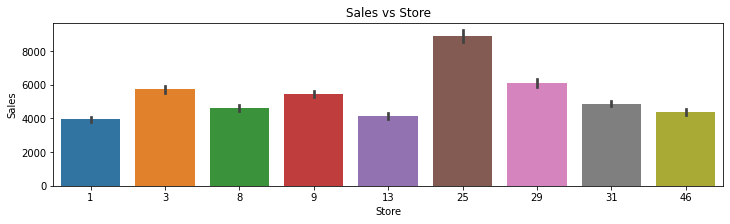

--------------------------------------------------


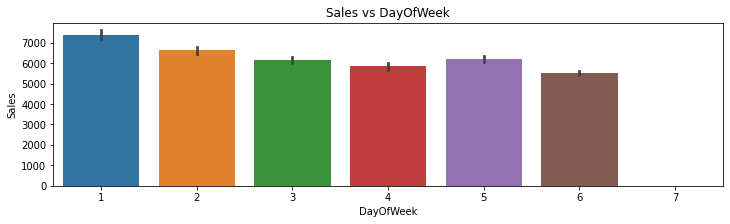

--------------------------------------------------


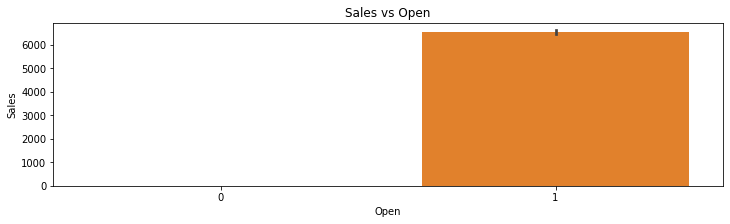

--------------------------------------------------


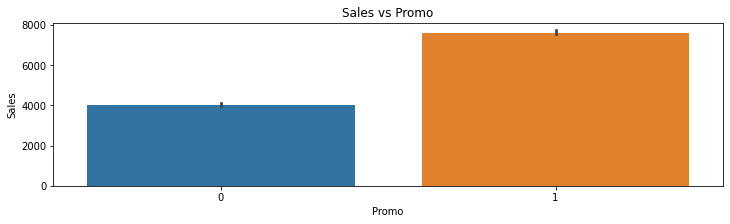

--------------------------------------------------


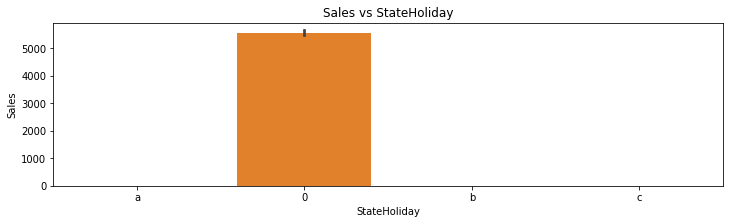

--------------------------------------------------


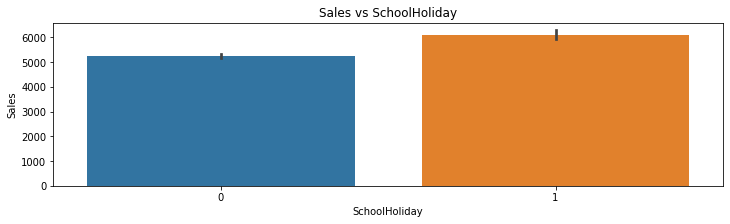

--------------------------------------------------


In [13]:
# checking the Sales trend against categorical columns

categ_cols = data_final.select_dtypes(include=['object','uint8','int64']).columns

for col in categ_cols:
    plt.figure(figsize=(12,3))
    plt.title(f'Sales vs {col}')
    sns.barplot(x=col, y='Sales', data=data_final)
    plt.show()
    print('-'*50)

### Insights
- DayofWeek=7 has 0 sales, which means 7th day is closed for the above stores
- Sales are only recorded when Open=1, which logically makes sense as well
- Sales are higher when there is a promo running in the stores
- Sales are recorded when Stateholiday=0

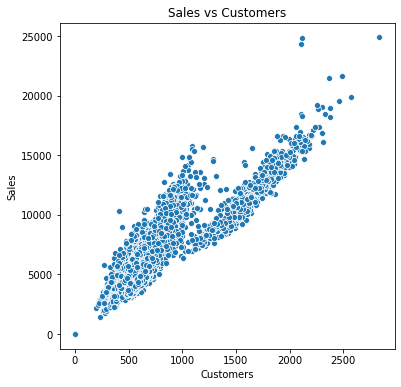

In [14]:
# checking the Sales trend against only numerical column ('Customers')

plt.figure(figsize=(6,6))
plt.title(f'Sales vs Customers')
sns.scatterplot(x='Customers', y='Sales', data=data_final)
plt.show()

### Insights

- There seems to be a linear trend between 'Sales' and 'Customers' column

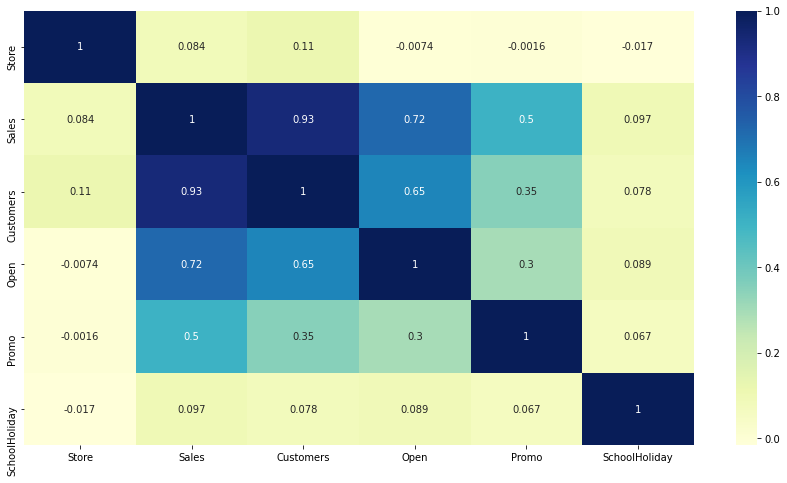

In [15]:
# lets check the correlation plot amongst the variables

plt.figure(figsize=(15,8))
sns.heatmap(data_final.corr(), annot=True, cmap="YlGnBu")
plt.show()

### Insights
- From the correlation plot, there seems to be a clear correlation between 'Sales' and variables such as 'Customers', 'Open' and 'Promo'

#### Dummy variables creation

In [16]:
cols_dummy = ['DayOfWeek', 'StateHoliday']

for col in cols_dummy:
    temp_df = pd.get_dummies(data_final[col], drop_first=True, prefix=col)
    data_final = pd.concat([data_final, temp_df], axis=1)
    data_final.drop(col, axis=1, inplace=True)

data_final.head()

Store       Date   Sales  Customers  Open  Promo  SchoolHoliday  \
1016095      1 2013-01-01     0.0          0     0      0              1   
1014980      1 2013-01-02  5530.0        668     1      0              1   
1013865      1 2013-01-03  4327.0        578     1      0              1   
1012750      1 2013-01-04  4486.0        619     1      0              1   
1011635      1 2013-01-05  4997.0        635     1      0              1   

         DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  \
1016095            1            0            0            0            0   
1014980            0            1            0            0            0   
1013865            0            0            1            0            0   
1012750            0            0            0            1            0   
1011635            0            0            0            0            1   

         DayOfWeek_7  StateHoliday_a  StateHoliday_b  StateHoliday_c  
1016095            0               1               0               0  
1014980            0               0               0               0  
1013865            0               0               0               0  
1012750            0               0               0               0  
1011635            0               0               0               0

In [17]:
# There are multiple rows with 0 Sales/Customers values in the dataset. This will cause problems when we will 
# calculate mape to assess our models

data_final['Sales'] = data_final['Sales'] + 1
data_final['Customers'] = data_final['Customers'] + 1

<b>Let's check storewise data</b>

In [18]:
temp_analysis = data_final.pivot_table(values='Date', index='Store', aggfunc=['min','max'])
temp_analysis.columns = ['start_date', 'end_date']
temp_analysis['Days'] = (temp_analysis['end_date'] - temp_analysis['start_date']).dt.days + 1
temp_analysis

start_date   end_date  Days
Store                            
1     2013-01-01 2015-07-31   942
3     2013-01-01 2015-07-31   942
8     2013-01-01 2015-07-31   942
9     2013-01-01 2015-07-31   942
13    2013-01-01 2015-07-31   942
25    2013-01-01 2015-07-31   942
29    2013-01-01 2015-07-31   942
31    2013-01-01 2015-07-31   942
46    2013-01-01 2015-07-31   942

As we can see from above all the stores have the same starting and ending date and should have 942 days of data. Let's check the stores for the same

In [19]:
data_final.groupby(by='Store')['Store'].count()

Store
1     942
3     942
8     942
9     942
13    758
25    942
29    942
31    942
46    758
Name: Store, dtype: int64

### Insight
- <b>Missing Data: </b>Store 13 and 46 have only 758 days of data and not 942 days. Hence, we will have to impute the missing data for them

In [20]:
# imputing missing data using past years data

for store in [13,46]:
    temp = data_final[(data_final['Store']==store)] #
    temp = temp.set_index('Date').asfreq(freq='D')
    
    prevDataReplace(temp,'2014-07-01','2015-01-02',store,'Sales')
    prevDataReplace(temp,'2014-07-01','2015-01-02',store,'Customers')
    temp['Store'] = store
    temp.sort_values(by=['Date'], ascending=True, axis=0, inplace=True)
    
    temp = temp.reset_index()
    
    data_final = data_final.drop(data_final[data_final['Store']==store].index, axis=0)
    data_final = pd.concat([data_final, temp], axis=0)

data_final.sort_values(by=['Store','Date'], ascending=True, axis=0, inplace=True)

In [21]:
# Values for other columns need to be imputed for the newly added rows for store 13 and 46
# Also, since sales/customers data is 0 for all Weekday_7, hence we change the frequency of our data to 6 business days

#custom working week mask
custom_bweekMask = "Mon Tue Wed Thu Fri Sat"    
custom_bweekIndex = pd.bdate_range(data_final.Date.min(), 
                                   data_final.Date.max(), 
                                   freq="C", 
                                   weekmask=custom_bweekMask)

li_df_storeWiseData = []
normalizingDict_sales = {}
normalizingDict_customers = {}

for storeId in list_stores:
    
    ### impute missing date for filtered store data
    store_data = data_final[data_final['Store'] == storeId].set_index('Date')
    store_data = store_data.asfreq(freq='D')
    store_data.sort_values(by=['Date'], ascending=True, axis=0, inplace=True)
    
    ### since as per our data, week starts from Monday as 1
    store_data['DayOfWeek'] = store_data.index.dayofweek + 1
    
    store_data = store_data.reset_index()
    
    # filtering out the Sunday data since our target stores are closed for this DayOfWeek
    store_data = store_data[store_data['DayOfWeek'] != 7]
    store_data = store_data.set_index(custom_bweekIndex)
    store_data.sort_index(inplace=True)

    store_data['Sales'] = store_data['Sales'].fillna(store_data['Sales'].mean())
    store_data['Customers'] = store_data['Customers'].fillna(store_data['Customers'].mean())
        
    ### for imputed data, setting applicable flags to False
    store_data['Promo'] = store_data['Promo'].fillna(0)
    store_data['SchoolHoliday'] = store_data['SchoolHoliday'].fillna(0)
    
    
    store_data['DayOfWeek_2'] = store_data['DayOfWeek'].apply(lambda x: 1 if x == 2 else 0).astype('uint8')
    store_data['DayOfWeek_3'] = store_data['DayOfWeek'].apply(lambda x: 1 if x == 3 else 0).astype('uint8')
    store_data['DayOfWeek_4'] = store_data['DayOfWeek'].apply(lambda x: 1 if x == 4 else 0).astype('uint8')
    store_data['DayOfWeek_5'] = store_data['DayOfWeek'].apply(lambda x: 1 if x == 5 else 0).astype('uint8')
    store_data['DayOfWeek_6'] = store_data['DayOfWeek'].apply(lambda x: 1 if x == 6 else 0).astype('uint8')
    
    store_data.drop(['Date','DayOfWeek','DayOfWeek_7'], axis=1, inplace=True)
    
    ### forward filling other blank values
    store_data.fillna(method='ffill', inplace=True)
    
    # map the correct data type
    store_data[['Open','Promo','SchoolHoliday','StateHoliday_a','StateHoliday_b',
                  'StateHoliday_c']] = store_data[['Open','Promo','SchoolHoliday','StateHoliday_a',
                                                     'StateHoliday_b', 'StateHoliday_c']].astype('uint8')
    
    ### Outlier handling - capping values at 99 percentile
    sales_Quantile = store_data["Sales"].quantile(0.99)
    customers_Quantile = store_data["Customers"].quantile(0.99)
    
    store_data["Sales"] = store_data["Sales"].apply(lambda x: 
                                                      sales_Quantile if x > sales_Quantile else x).astype('float64')
    store_data["Customers"] = store_data["Customers"].apply(lambda x: 
                                              customers_Quantile if x > customers_Quantile else x).astype('float64')
    
    ### Standardize values - Min-Max scaling
    sales_min, sales_max = store_data["Sales"].min(), store_data["Sales"].max()
    normalizingDict_sales[storeId] = [sales_min, sales_max]
    store_data["Sales"] = normalize(store_data["Sales"], sales_min, sales_max)
    
    cust_min, cust_max = store_data["Customers"].min(), store_data["Customers"].max()
    normalizingDict_customers[storeId] = [cust_min, cust_max]
    store_data["Customers"] = normalize(store_data["Customers"], cust_min, cust_max)
    
    li_df_storeWiseData.append(store_data)
    
data_final_new = pd.concat(li_df_storeWiseData, axis=0)

data_final_new.head(10)

Store     Sales  Customers  Open  Promo  SchoolHoliday  \
2013-01-01    1.0  0.000000   0.000000     0      0              1   
2013-01-02    1.0  0.701068   0.768231     1      0              1   
2013-01-03    1.0  0.548558   0.664727     1      0              1   
2013-01-04    1.0  0.568715   0.711879     1      0              1   
2013-01-05    1.0  0.633497   0.730280     1      0              1   
2013-01-07    1.0  0.909741   0.902787     1      1              1   
2013-01-08    1.0  0.707407   0.752130     1      1              1   
2013-01-09    1.0  0.693589   0.719929     1      1              1   
2013-01-10    1.0  0.620186   0.707279     1      1              1   
2013-01-11    1.0  0.618791   0.680828     1      1              1   

            DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  \
2013-01-01            1            0            0            0            0   
2013-01-02            0            1            0            0            0   
2013-01-03            0            0            1            0            0   
2013-01-04            0            0            0            1            0   
2013-01-05            0            0            0            0            1   
2013-01-07            0            0            0            0            0   
2013-01-08            1            0            0            0            0   
2013-01-09            0            1            0            0            0   
2013-01-10            0            0            1            0            0   
2013-01-11            0            0            0            1            0   

            StateHoliday_a  StateHoliday_b  StateHoliday_c  
2013-01-01               1               0               0  
2013-01-02               0               0               0  
2013-01-03               0               0               0  
2013-01-04               0               0               0  
2013-01-05               0               0               0  
2013-01-07               0               0               0  
2013-01-08               0               0               0  
2013-01-09               0               0               0  
2013-01-10               0               0               0  
2013-01-11               0               0               0

## Model preparation

Before we start with model preparation, lets first check the correlation between our data vars

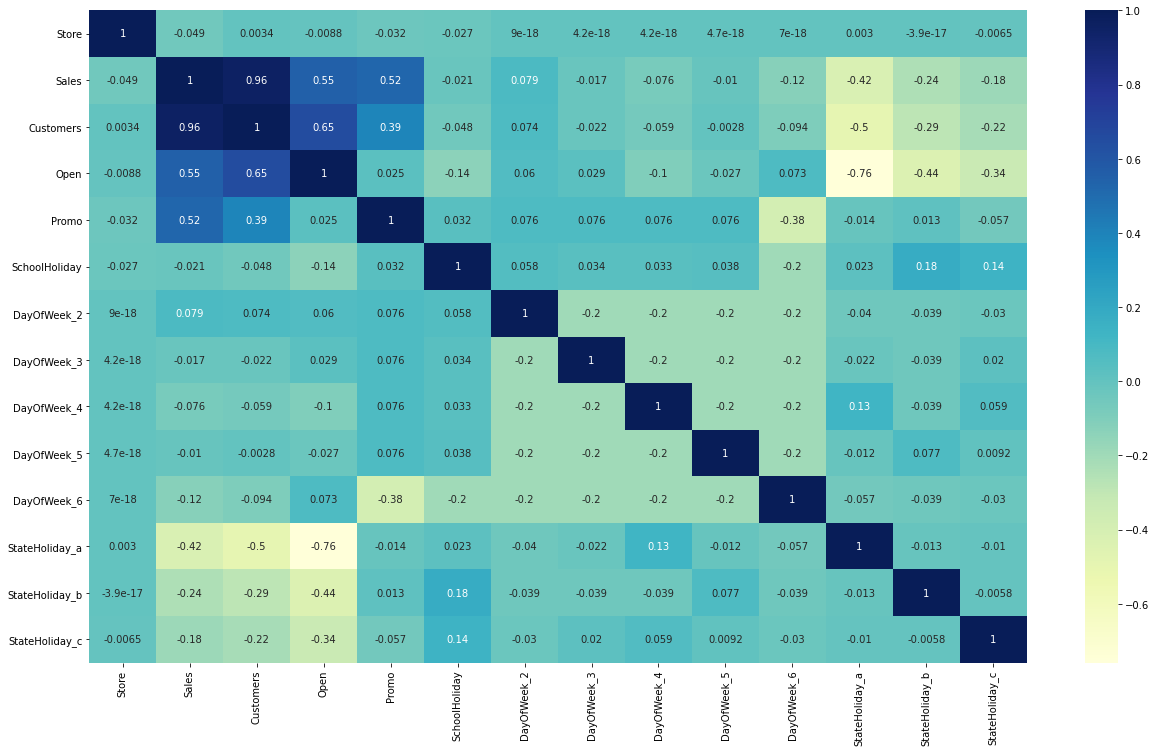

In [22]:
plt.figure(figsize=(21,12))
sns.heatmap(data_final_new.corr(), annot=True, cmap="YlGnBu")
plt.show()

# Stationarity test

Since we are analysing the sales by individual stores, we would be checking the stationarity for Sales as store-wise as well. First, lets check the distribution of sales by stores:

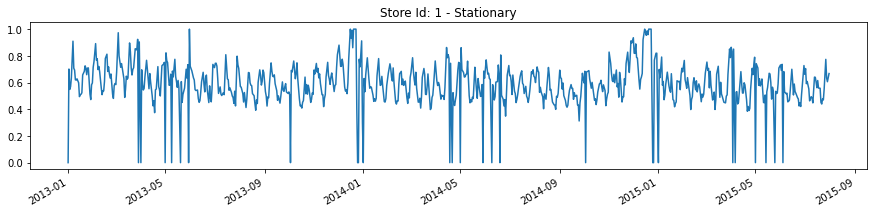

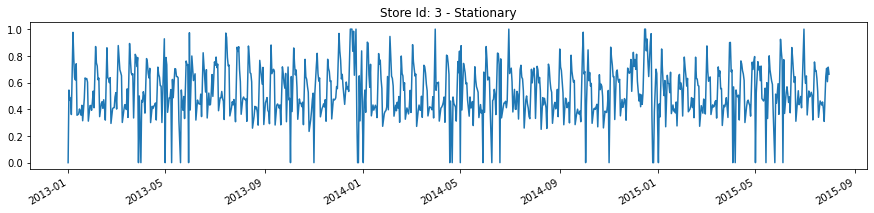

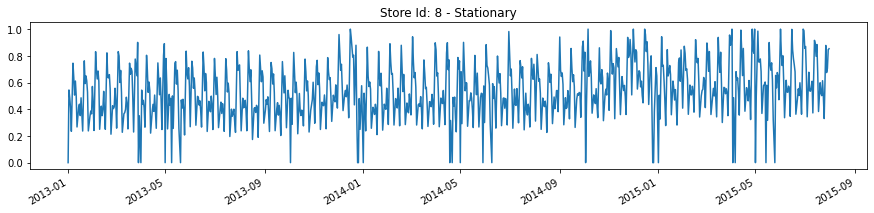

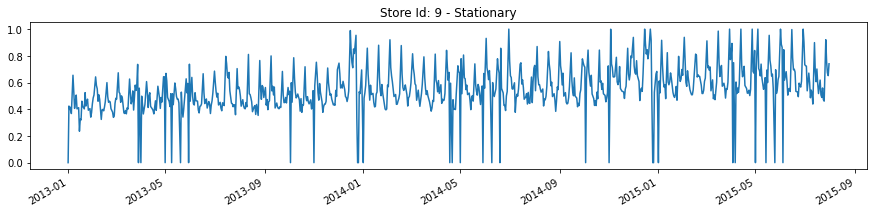

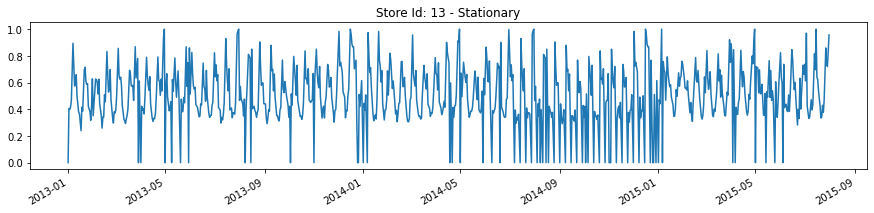

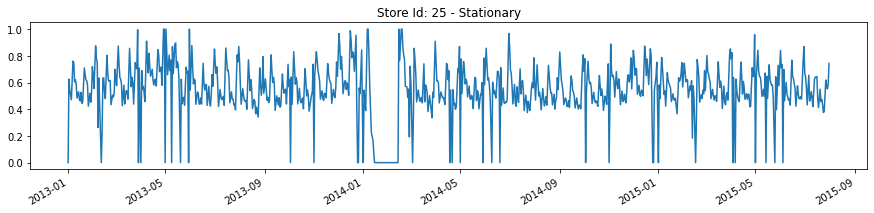

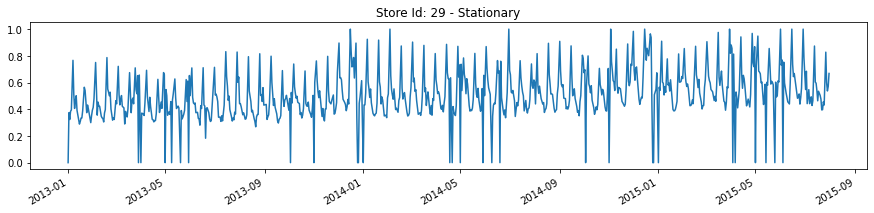

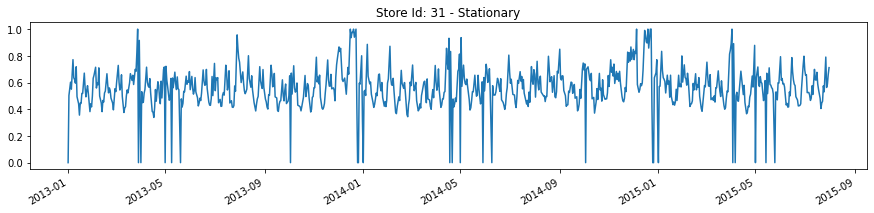

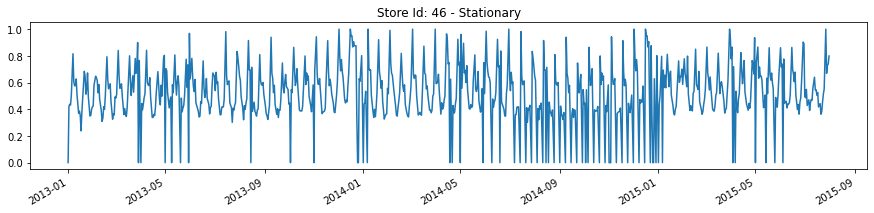

<Figure size 432x288 with 0 Axes>

In [23]:
list_stores = [1, 3, 8, 9, 13, 25, 29, 31, 46] 

for store in list_stores:
    store_sales = data_final_new[data_final_new['Store']==store]['Sales']
    
    adf_res = checkStationarity(store_sales)
    plt.figure(figsize=(15,3))
    store_sales.plot()
    plt.title(f"Store Id: {store} - {adf_res}")
    plt.show()
plt.tight_layout()

### Decomposing the series for all the stores

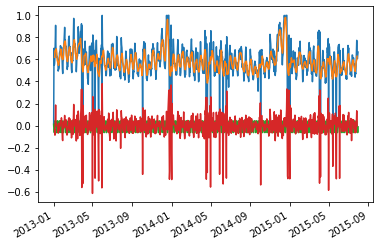

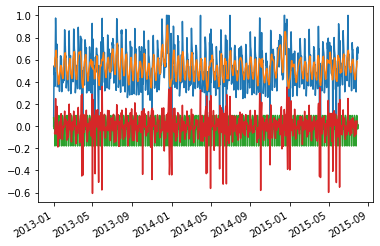

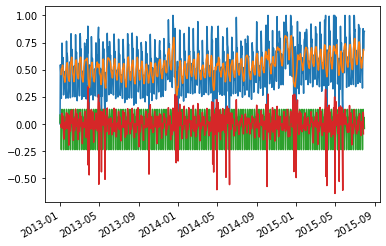

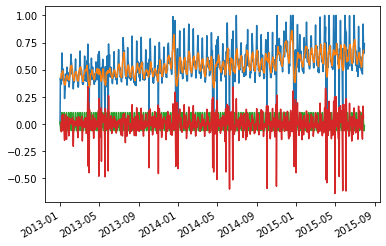

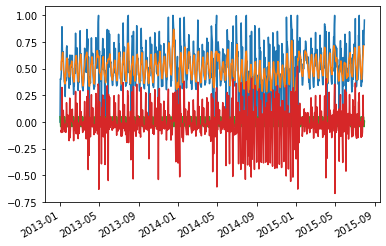

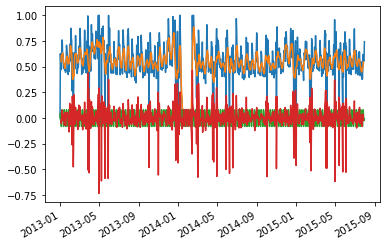

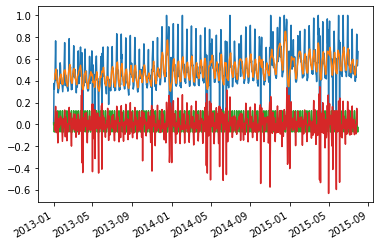

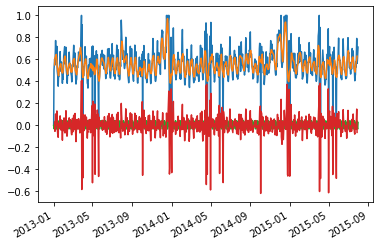

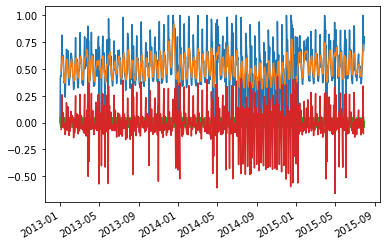

In [25]:
list_stores = [1, 3, 8, 9, 13, 25, 29, 31, 46] 

for store in list_stores:
#     for i in range(4):
    store_sales = data_final_new[data_final_new['Store']==store]['Sales']
    decomposition_fig = sm.tsa.seasonal_decompose(store_sales, model='additive', period=6)
    #     plt.figure(figsize=(20,5))
    decomposition_fig.observed.plot()
    decomposition_fig.trend.plot()
    decomposition_fig.seasonal.plot()
    decomposition_fig.resid.plot()
    plt.show()

In [26]:
# fig, axes = plt.subplots(nrows=len_stores*4, ncols=1, dpi=120, figsize=(12,80))

# for i, storeId in enumerate(list_stores):
#     sales_series = li_df_storeWiseData[i]['Sales']
    
#     decomposition_fig = sm.tsa.seasonal_decompose(sales_series, model='additive', period=6)
#     baseAdd = 3*i
# #     decomposition_fig.plot()
# #     plt.show()
#     decomposition_fig.observed.plot(ax=axes[i+baseAdd], legend=False)
#     axes[i+baseAdd].set_ylabel(f'Observed - {storeId}')
#     decomposition_fig.trend.plot(ax=axes[i+baseAdd+1], legend=False)
#     axes[i+baseAdd+1].set_ylabel(f'Trend - {storeId}')
#     decomposition_fig.seasonal.plot(ax=axes[i+baseAdd+2], legend=False)
#     axes[i+baseAdd+2].set_ylabel(f'Seasonal - {storeId}')
#     decomposition_fig.resid.plot(ax=axes[i+baseAdd+3], legend=False)
#     axes[i+baseAdd+3].set_ylabel(f'Residual - {storeId}')
#     print('-'*50)
    
# plt.tight_layout()

### Plotting ACF & PACF

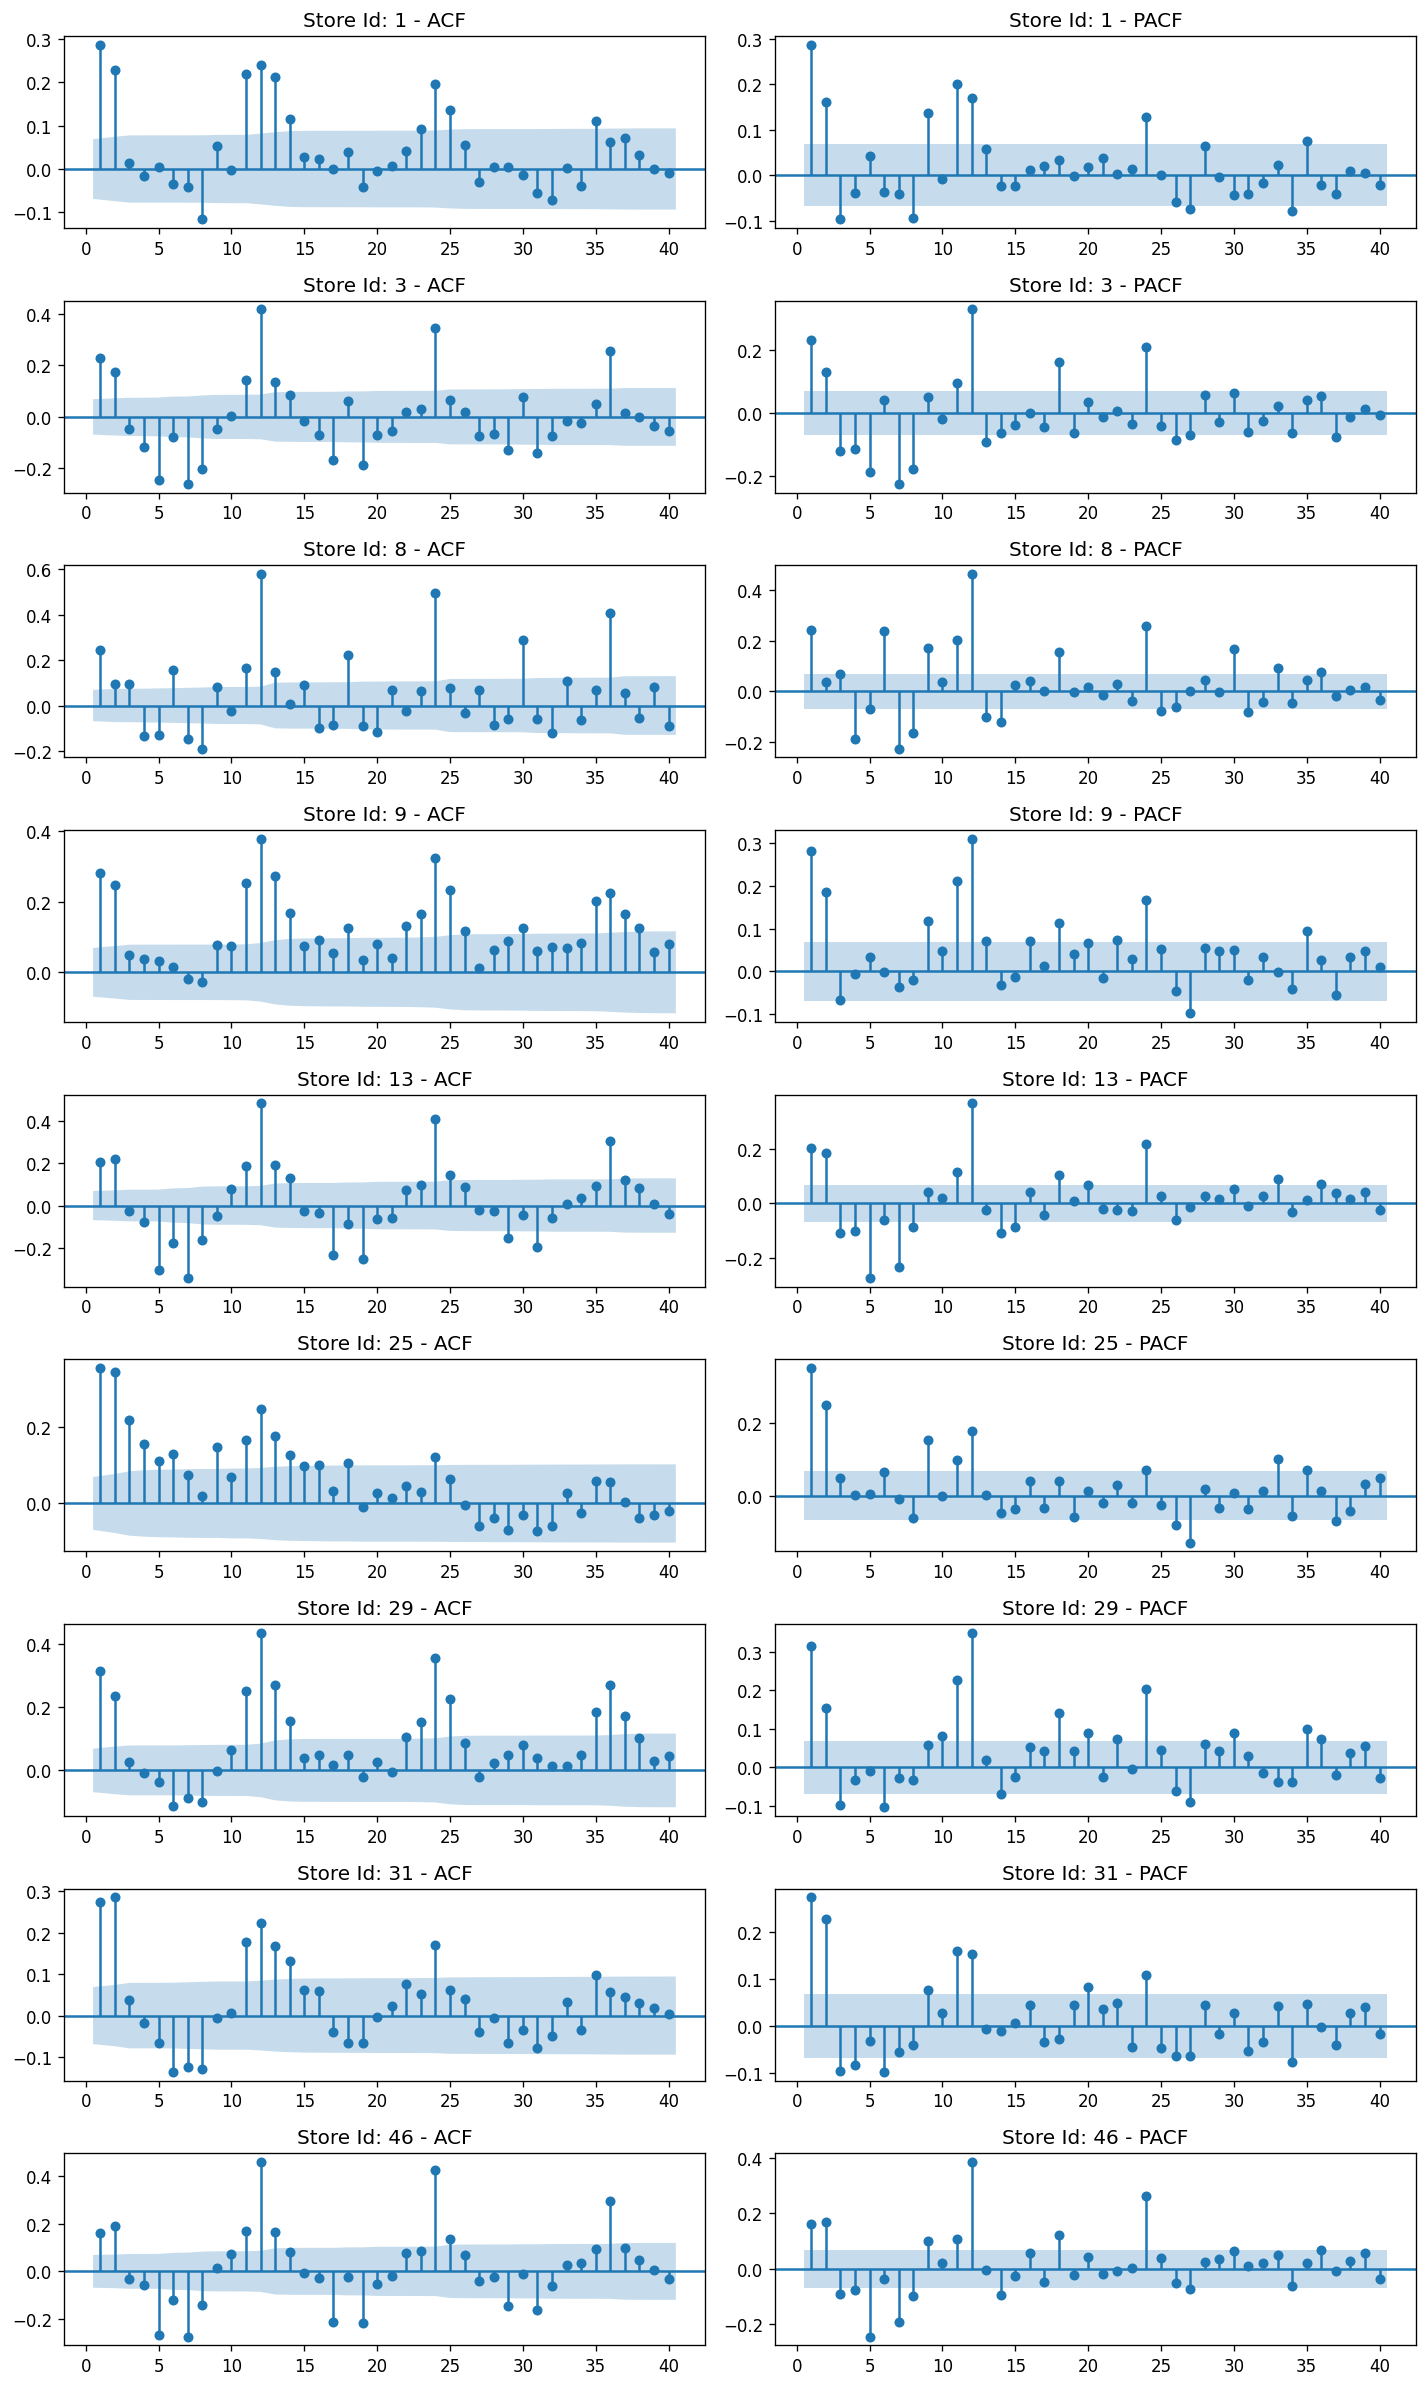

In [27]:
fig, axes = plt.subplots(nrows=len_stores, ncols=2, dpi=120, figsize=(12,20))
lags_size = 40
for i, storeId in enumerate(list_stores):
    sales_series = li_df_storeWiseData[i]['Sales']
    
    # ACF: MA-value
    plot_acf(sales_series, ax=axes[i][0], lags=lags_size, zero=False, title=f"Store Id: {storeId} - ACF")
    
    # PACF: AR-value
    plot_pacf(sales_series, ax=axes[i][1], lags=lags_size, zero=False, title=f"Store Id: {storeId} - PACF")
    
    
plt.tight_layout()

### Observations

From the above charts, we see similar charts for all the stores
- ACF: q=0, Q=0
- PACF: p=11, P=4
- Seasonality: m=12

### Test-train split

In [28]:
train_data, test_data = [], []
threshold_date_train = '2015-06-19'
threshold_date_test = '2015-06-20'

for i, storeId in enumerate(list_stores):
    store_data = li_df_storeWiseData[i]
    loc_train = store_data.loc[:threshold_date_train]
    loc_test = store_data.loc[threshold_date_test:]
    
    print(f"Store: {storeId}, train-shape: {loc_train.shape}, test-shape: {loc_test.shape}")
    
    train_data.append(loc_train)
    test_data.append(loc_test)

Store: 1, train-shape: (772, 14), test-shape: (36, 14)
Store: 3, train-shape: (772, 14), test-shape: (36, 14)
Store: 8, train-shape: (772, 14), test-shape: (36, 14)
Store: 9, train-shape: (772, 14), test-shape: (36, 14)
Store: 13, train-shape: (772, 14), test-shape: (36, 14)
Store: 25, train-shape: (772, 14), test-shape: (36, 14)
Store: 29, train-shape: (772, 14), test-shape: (36, 14)
Store: 31, train-shape: (772, 14), test-shape: (36, 14)
Store: 46, train-shape: (772, 14), test-shape: (36, 14)


In [29]:
### defining common model parameters and creating a summary dataframe

mod_p, mod_P, mod_q, mod_Q, mod_d, mod_D, mod_m = 11, 4, 0, 0, 0, 0, 12

summary_df = pd.DataFrame(data={}, columns=['Model','Store','RMSE','MAPE'])

### 1. ARIMA Model

Wall time: 23.3 s


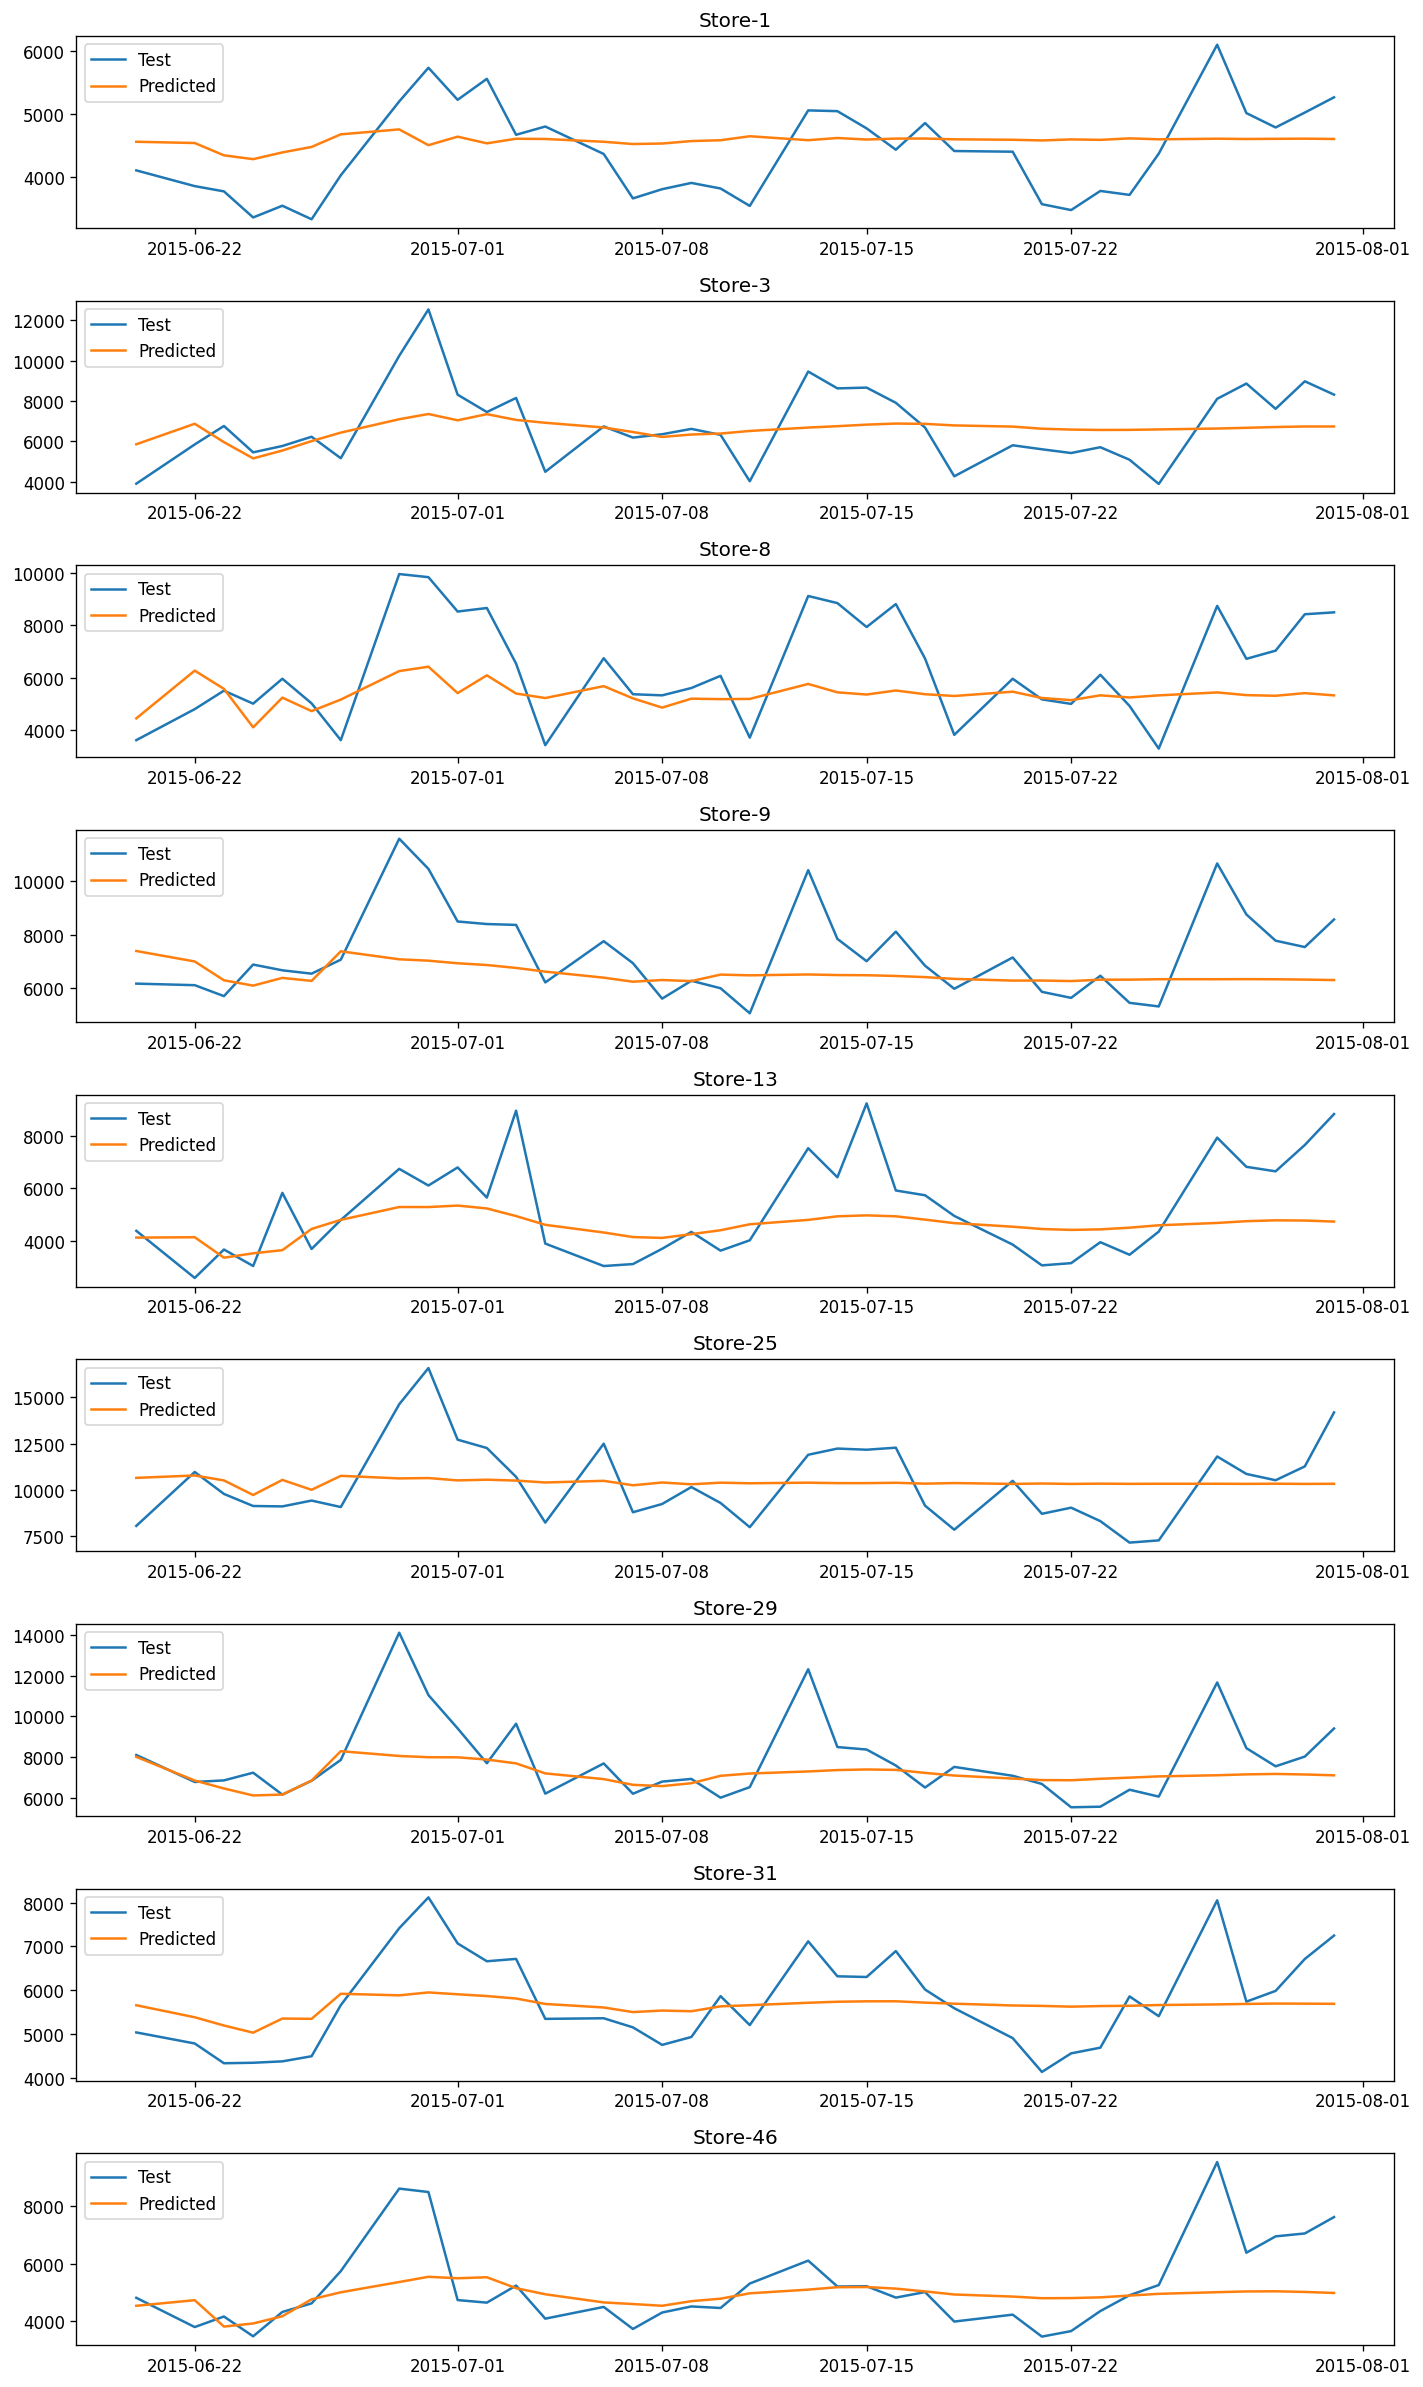

In [30]:
%%time
endogVarname = 'Sales'

fig, axes = plt.subplots(nrows=len_stores, ncols=1, dpi=120, figsize=(12,20))

for i, storeId in enumerate(list_stores):
    model_arima = ARIMA(train_data[i][endogVarname], order=(11, mod_d, mod_q))
    model_arima_fit = model_arima.fit()
    
    y_pred = li_df_storeWiseData[i]
    
    min_sale_val, max_sale_val = normalizingDict_sales.get(storeId)
    
    y_pred['prediction'] = model_arima_fit.predict(y_pred.index.min(), y_pred.index.max())
    
    
    # de-normalize these sales columns for evaluation
    sales_actual = denormalize(test_data[i][endogVarname], min_sale_val, max_sale_val)
    sales_predicted_arima = denormalize(y_pred['prediction'][test_data[i].index.min():], min_sale_val, max_sale_val)
    
    # plot
    axes[i].plot(sales_actual, label='Test')
    axes[i].plot(sales_predicted_arima, label='Predicted')
    axes[i].legend(loc='upper left')
    ptitle = f"Store-{storeId}"
    axes[i].set_title(ptitle)
    
    arima_rmse, arima_mape = rmse_mape(sales_actual, sales_predicted_arima)
    summary_df = summary_df.append({'Model': 'ARIMA',
                                    'Store': storeId,
                                    'RMSE': arima_rmse,
                                    'MAPE': arima_mape}, ignore_index=True)
    
plt.tight_layout()

In [31]:
summary_df[summary_df['Model'] == 'ARIMA']

Model Store     RMSE   MAPE
0  ARIMA     1   719.51  14.94
1  ARIMA     3  1751.90  21.25
2  ARIMA     8  1986.70  24.60
3  ARIMA     9  1699.20  15.80
4  ARIMA    13  1758.18  24.25
5  ARIMA    25  2087.22  16.69
6  ARIMA    29  1806.31  12.80
7  ARIMA    31   963.58  13.68
8  ARIMA    46  1369.54  15.60

### Observations

- Since this model does not incorporate the seasonality aspect, we can see the RMSE and MAPE scores are not very good for this model. Next, we would check the impact of introducing seasonality dependency using SARIMA model

### 2. SARIMA Model

C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retva

Wall time: 5min 36s


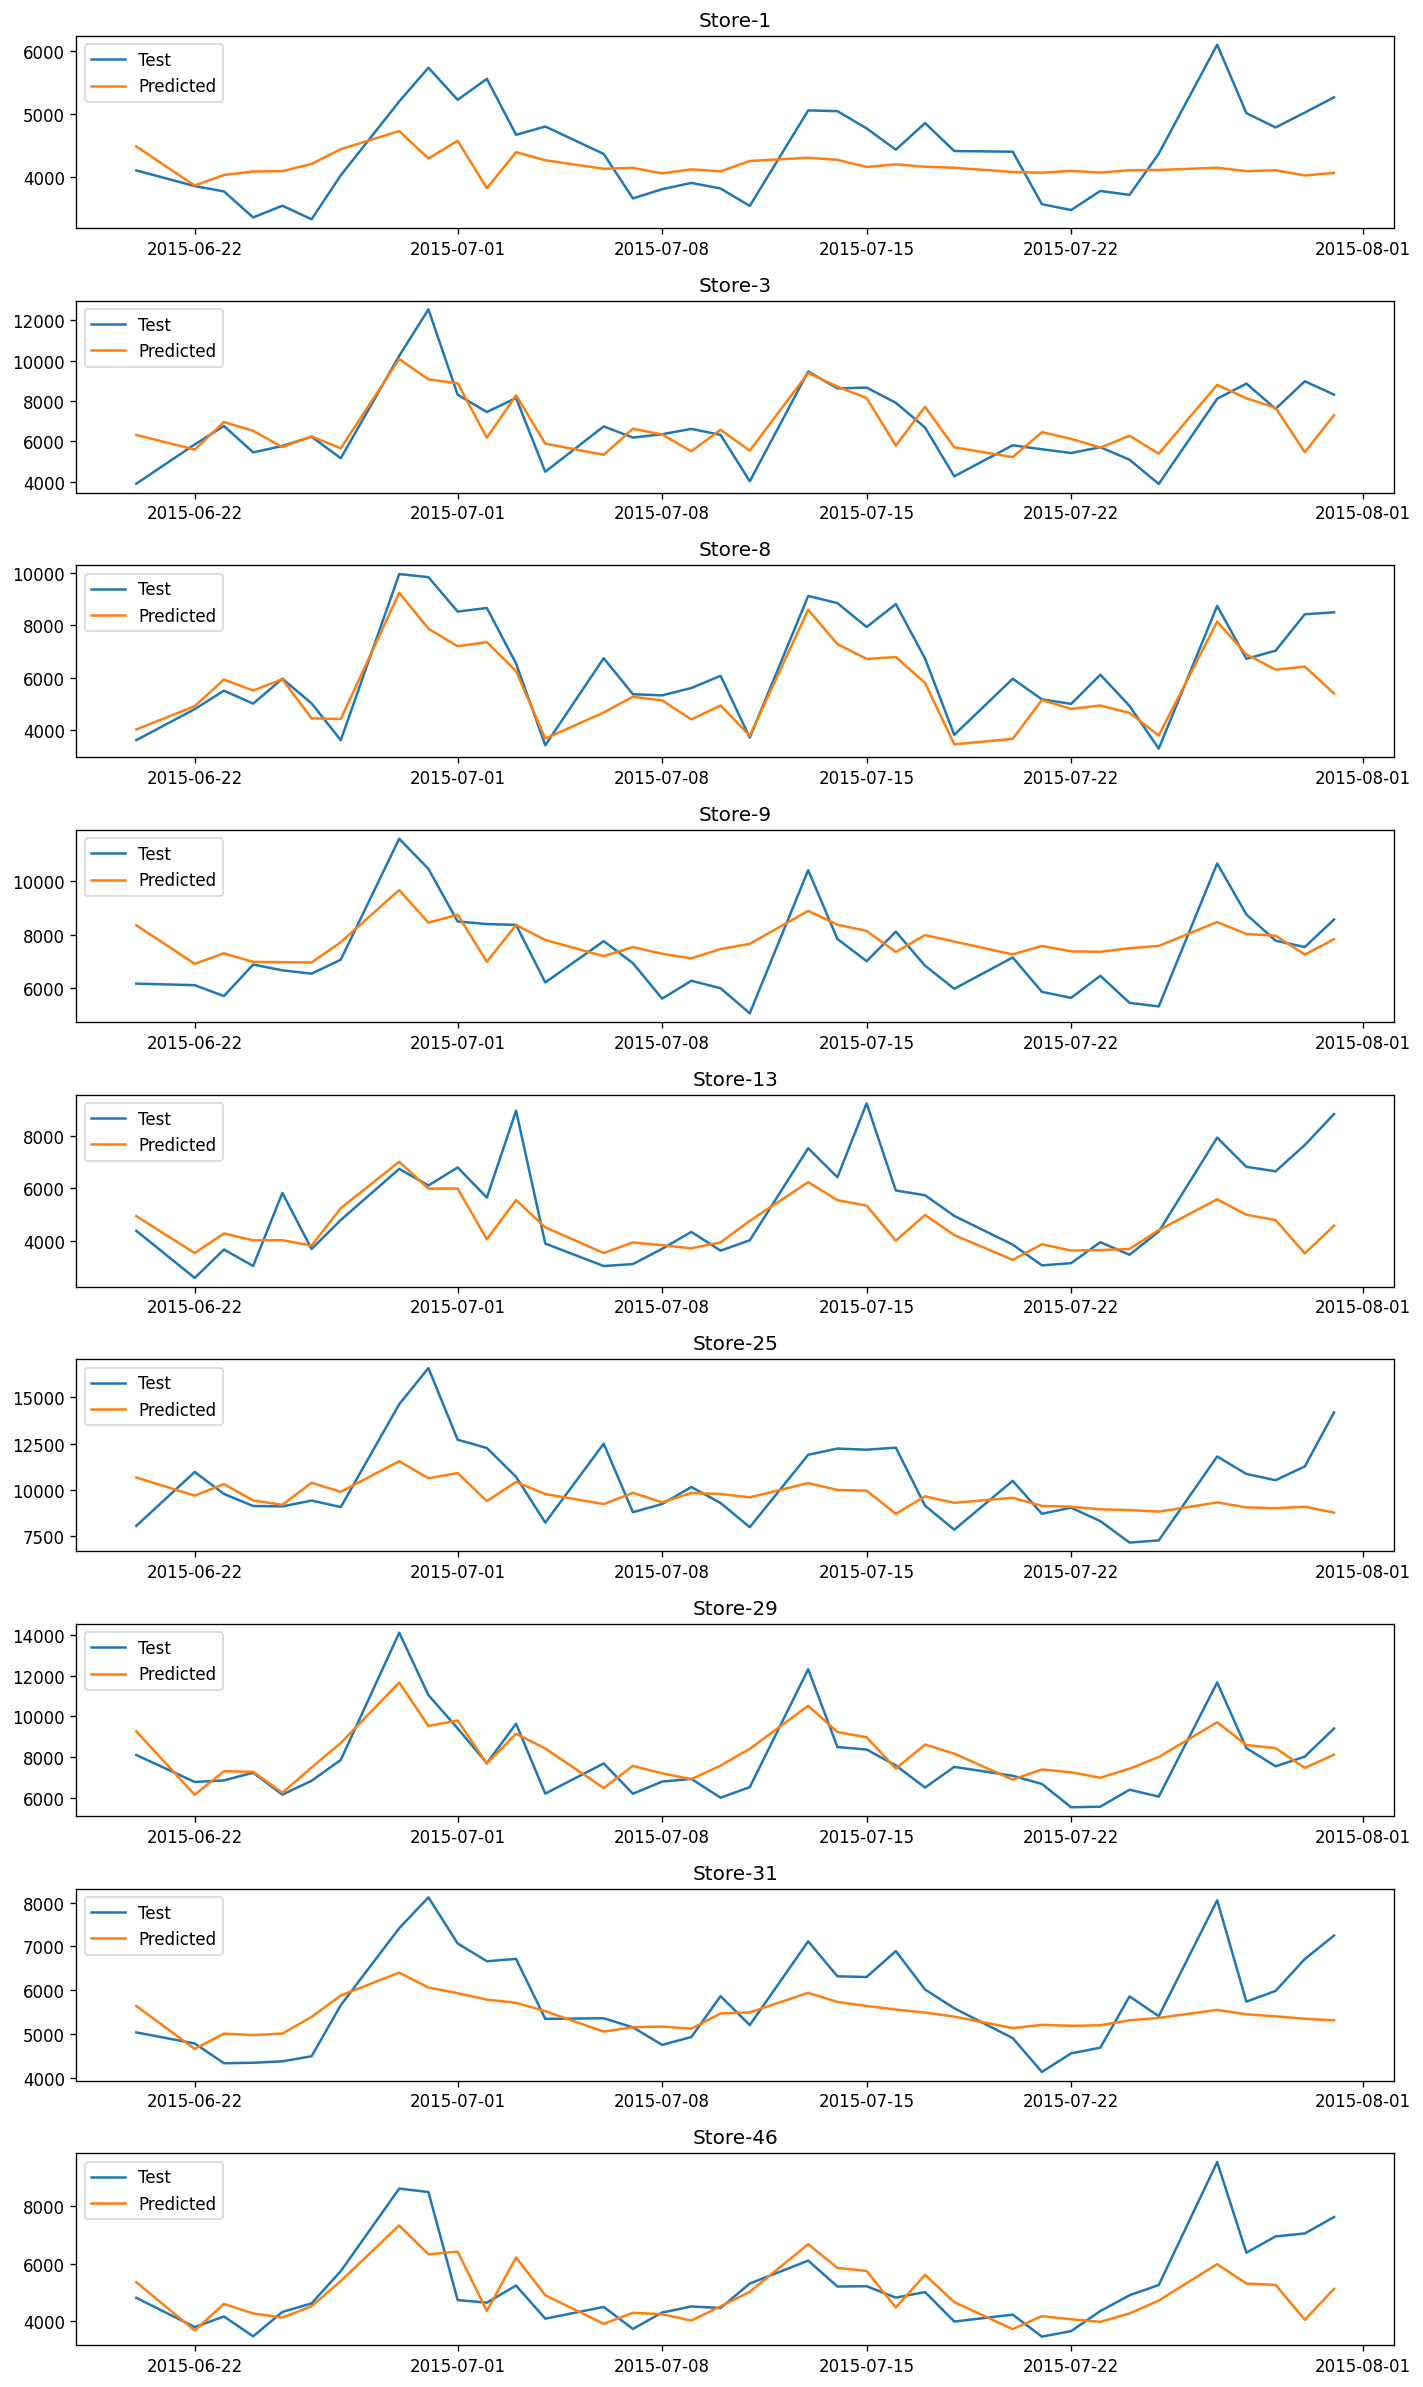

In [32]:
%%time
endogVarname = 'Sales'

mod_p, mod_P, mod_q, mod_Q, mod_d, mod_D, mod_m = 11, 4, 0, 0, 0, 0, 12

fig, axes = plt.subplots(nrows=len_stores, ncols=1, dpi=120, figsize=(12,20))

for i, storeId in enumerate(list_stores):
    model_sarima = sm.tsa.statespace.SARIMAX(train_data[i][endogVarname], order=(mod_p, mod_d, mod_q), 
                                      seasonal_order=(mod_P, mod_D, mod_Q, mod_m))
    model_sarima_fit = model_sarima.fit()
    
    y_pred = li_df_storeWiseData[i]
    
    min_sale_val, max_sale_val = normalizingDict_sales.get(storeId)
    
    y_pred['prediction'] = model_sarima_fit.predict(y_pred.index.min(), y_pred.index.max())
    
    
    # de-normalize these sales columns for evaluation
    sales_actual = denormalize(test_data[i][endogVarname], min_sale_val, max_sale_val)
    sales_predicted_sarima = denormalize(y_pred['prediction'][test_data[i].index.min():], min_sale_val, max_sale_val)
    
    # plot
    axes[i].plot(sales_actual, label='Test')
    axes[i].plot(sales_predicted_sarima, label='Predicted')
    axes[i].legend(loc='upper left')
    ptitle = f"Store-{storeId}"
    axes[i].set_title(ptitle)
    
    sarima_rmse, sarima_mape = rmse_mape(sales_actual, sales_predicted_sarima)
    summary_df = summary_df.append({'Model': 'SARIMA',
                                    'Store': storeId,
                                    'RMSE': sarima_rmse,
                                    'MAPE': sarima_mape}, ignore_index=True)
    
plt.tight_layout()

In [33]:
summary_df[summary_df['Model'] == 'SARIMA']

Model Store     RMSE   MAPE
9   SARIMA     1   745.70  13.48
10  SARIMA     3  1256.36  14.62
11  SARIMA     8  1148.47  12.81
12  SARIMA     9  1336.80  16.74
13  SARIMA    13  1612.95  19.92
14  SARIMA    25  2129.64  14.85
15  SARIMA    29  1197.48  12.96
16  SARIMA    31   916.42  11.87
17  SARIMA    46  1166.98  14.64

### Observations

- As can be seen from the graph Test and predicted lines are much closer
- RMSE and MAPE values have also improved
- Next, we would try to introduce the dependency of some external variables (exogs) on top of our SARIMA model. For this we would need to decide the important exog variables. We would use XGBoost to find the important features

### 3. Feature importance - XGBoost

In [34]:
from xgboost import XGBRegressor

#### Default model

In [35]:
%%time

li_feature_imp = []

for i, storeId in enumerate(list_stores):
    X_train = train_data[i][train_data[i].columns.difference([endogVarname,'Store'])]
    y_train = train_data[i][endogVarname]
    
    X_test = test_data[i][test_data[i].columns.difference([endogVarname,'Store'])]
    y_test = test_data[i][endogVarname]
    
    xgb_reg = XGBRegressor(n_jobs = -1)
    xbg_fit = xgb_reg.fit(X_train, 
                          y_train)
    
    min_sale_val, max_sale_val = normalizingDict_sales.get(storeId)
    
    y_pred = xgb_reg.predict(X_test)
    
    feature_imp = pd.DataFrame(xgb_reg.feature_importances_ , index=X_train.columns.to_list())
    li_feature_imp.append(feature_imp)
    
    # de-normalize these sales columns for evaluation
    sales_actual = denormalize(y_test, min_sale_val, max_sale_val)
    sales_predicted_xgb = denormalize(y_pred, min_sale_val, max_sale_val)
    
    
    xgb_rmse, xgb_mape = rmse_mape(sales_actual, sales_predicted_xgb)
    summary_df = summary_df.append({'Model': 'XGBoost',
                                    'Store': storeId,
                                    'RMSE': xgb_rmse,
                                    'MAPE': xgb_mape}, ignore_index=True)
    
feature_imp_df = pd.concat(li_feature_imp, axis=1)
feature_imp_df.columns=list_stores
feature_imp_df

[08:28:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:28:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

1         3         8         9         13        25  \
Customers       0.804585  0.821456  0.652456  0.904250  0.857117  0.894779   
DayOfWeek_2     0.004741  0.001634  0.002479  0.005409  0.004399  0.004255   
DayOfWeek_3     0.007286  0.004951  0.005095  0.004338  0.006882  0.004819   
DayOfWeek_4     0.009170  0.024727  0.060719  0.007630  0.013188  0.008207   
DayOfWeek_5     0.012906  0.018350  0.011170  0.009064  0.019288  0.006548   
DayOfWeek_6     0.020838  0.010617  0.006595  0.022038  0.016215  0.012957   
Open            0.000000  0.000000  0.000000  0.000000  0.000331  0.001449   
Promo           0.133014  0.115829  0.259204  0.042710  0.072745  0.057190   
SchoolHoliday   0.007460  0.002437  0.002282  0.004563  0.009550  0.009795   
StateHoliday_a  0.000000  0.000000  0.000000  0.000000  0.000284  0.000000   
StateHoliday_b  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
StateHoliday_c  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                      29        31        46  
Customers       0.928915  0.697866  0.802268  
DayOfWeek_2     0.002005  0.025393  0.001953  
DayOfWeek_3     0.006449  0.004573  0.009507  
DayOfWeek_4     0.007718  0.014415  0.016760  
DayOfWeek_5     0.013051  0.018211  0.015987  
DayOfWeek_6     0.003607  0.007334  0.084492  
Open            0.000000  0.000000  0.000000  
Promo           0.034133  0.225714  0.064471  
SchoolHoliday   0.003805  0.006494  0.004563  
StateHoliday_a  0.000316  0.000000  0.000000  
StateHoliday_b  0.000000  0.000000  0.000000  
StateHoliday_c  0.000000  0.000000  0.000000

### Observations

- 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c' and 'Open' do not seem to be providing much value. Hence we do not include them in our model

### 3. SARIMAX Model

C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retva

Wall time: 20min 23s


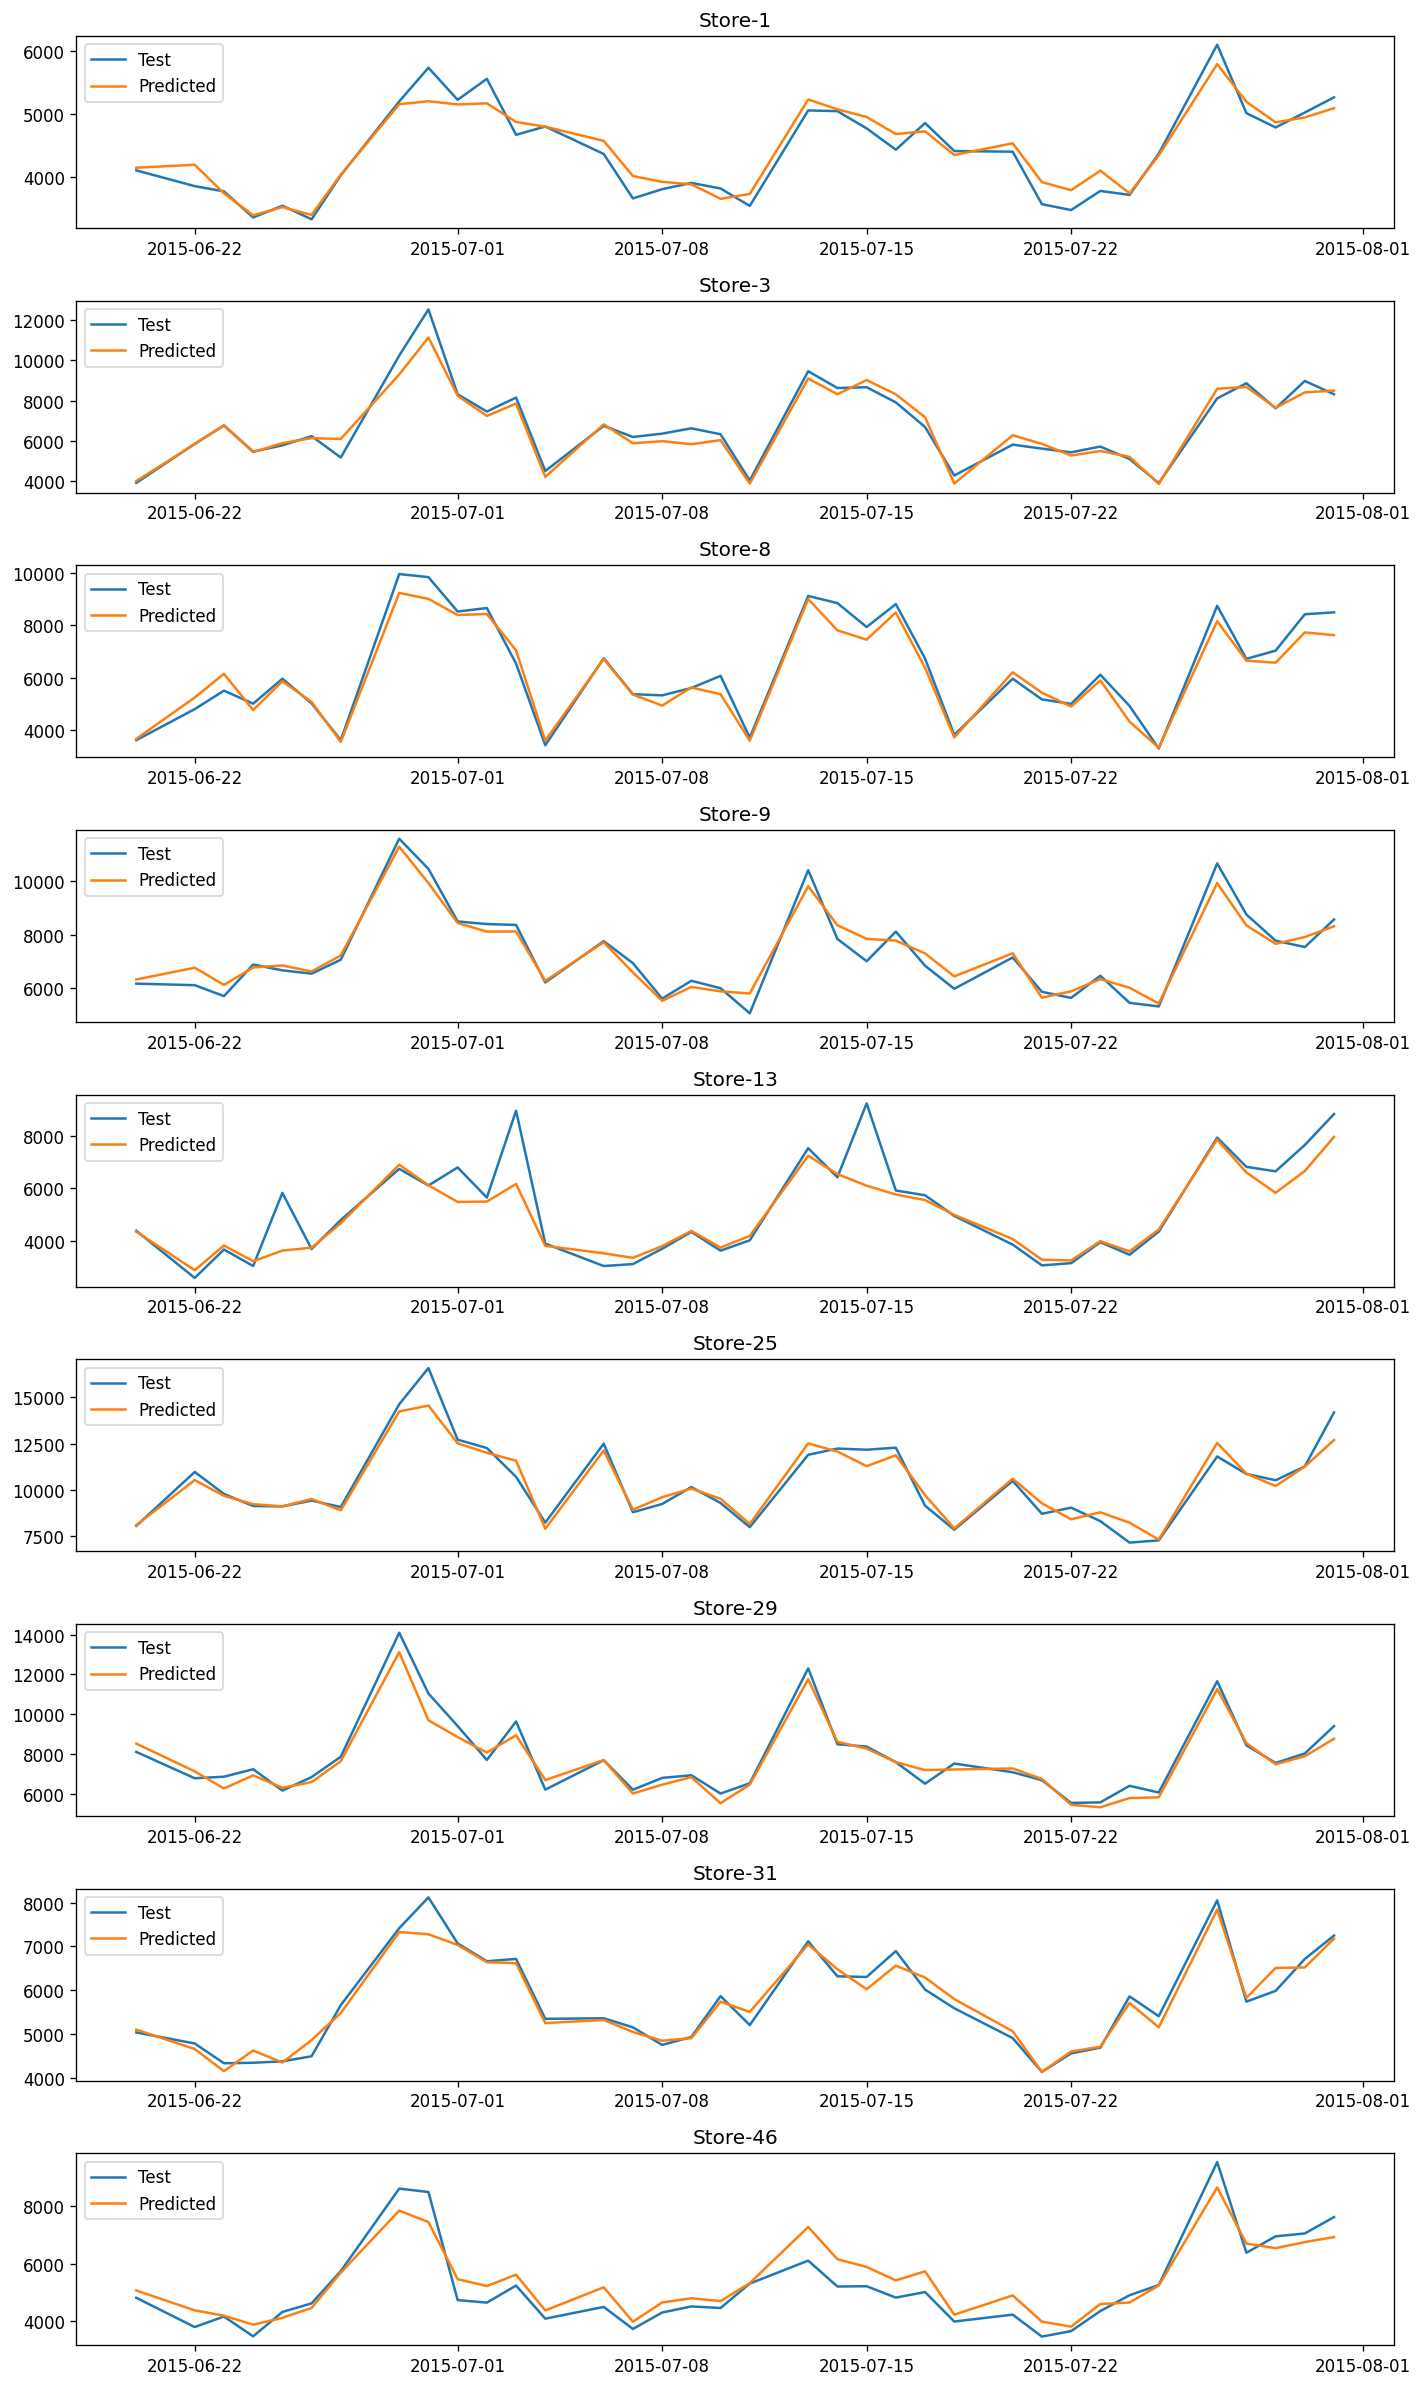

In [36]:
%%time
endogVarname = 'Sales'
exogVars = ['Customers','Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5',
            'DayOfWeek_6']

fig, axes = plt.subplots(nrows=len_stores, ncols=1, dpi=120, figsize=(12,20))

for i, storeId in enumerate(list_stores):
    model_sarimax = sm.tsa.statespace.SARIMAX(train_data[i][endogVarname], order=(mod_p, mod_d, mod_q), 
                                      seasonal_order=(mod_P, mod_D, mod_Q, mod_m),
                                     exog=train_data[i][train_data[i].columns.intersection(exogVars)])
    model_sarimax_fit = model_sarimax.fit()
    
    y_pred = li_df_storeWiseData[i]
    
    min_sale_val, max_sale_val = normalizingDict_sales.get(storeId)
    
    y_pred['prediction'] = model_sarimax_fit.predict(y_pred.index.min(), y_pred.index.max(),
                                            exog=test_data[i][test_data[i].columns.intersection(exogVars)])
    
    
    # de-normalize these sales columns for evaluation
    sales_actual = denormalize(test_data[i][endogVarname], min_sale_val, max_sale_val)
    sales_predicted_sarimax = denormalize(y_pred['prediction'][test_data[i].index.min():], min_sale_val, max_sale_val)
    
    # plot
    axes[i].plot(sales_actual, label='Test')
    axes[i].plot(sales_predicted_sarimax, label='Predicted')
    axes[i].legend(loc='upper left')
    ptitle = f"Store-{storeId}"
    axes[i].set_title(ptitle)
    
    sarimax_rmse, sarimax_mape = rmse_mape(sales_actual, sales_predicted_sarimax)
    summary_df = summary_df.append({'Model': 'SARIMAX',
                                    'Store': storeId,
                                    'RMSE': sarimax_rmse,
                                    'MAPE': sarimax_mape}, ignore_index=True)
    
plt.tight_layout()

In [37]:
summary_df[summary_df['Model'] == 'SARIMAX']

Model Store    RMSE  MAPE
27  SARIMAX     1  206.20  3.63
28  SARIMAX     3  436.43  4.56
29  SARIMAX     8  435.14  4.97
30  SARIMAX     9  379.27  4.41
31  SARIMAX    13  869.74  7.29
32  SARIMAX    25  587.98  3.71
33  SARIMAX    29  446.59  4.27
34  SARIMAX    31  235.38  2.92
35  SARIMAX    46  537.39  8.63

### Observations

- As can be seen, SARIMAX has provided amazing results both in terms of RMSE and MAPE and this turn out to be the best model. But we will see that later
- Next, we try using Vectorized models but before that we need to check if we have features that are cointegrated or not

### 3.2 SARIMAX Model (without Customers exog)

C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retva

Wall time: 19min 5s


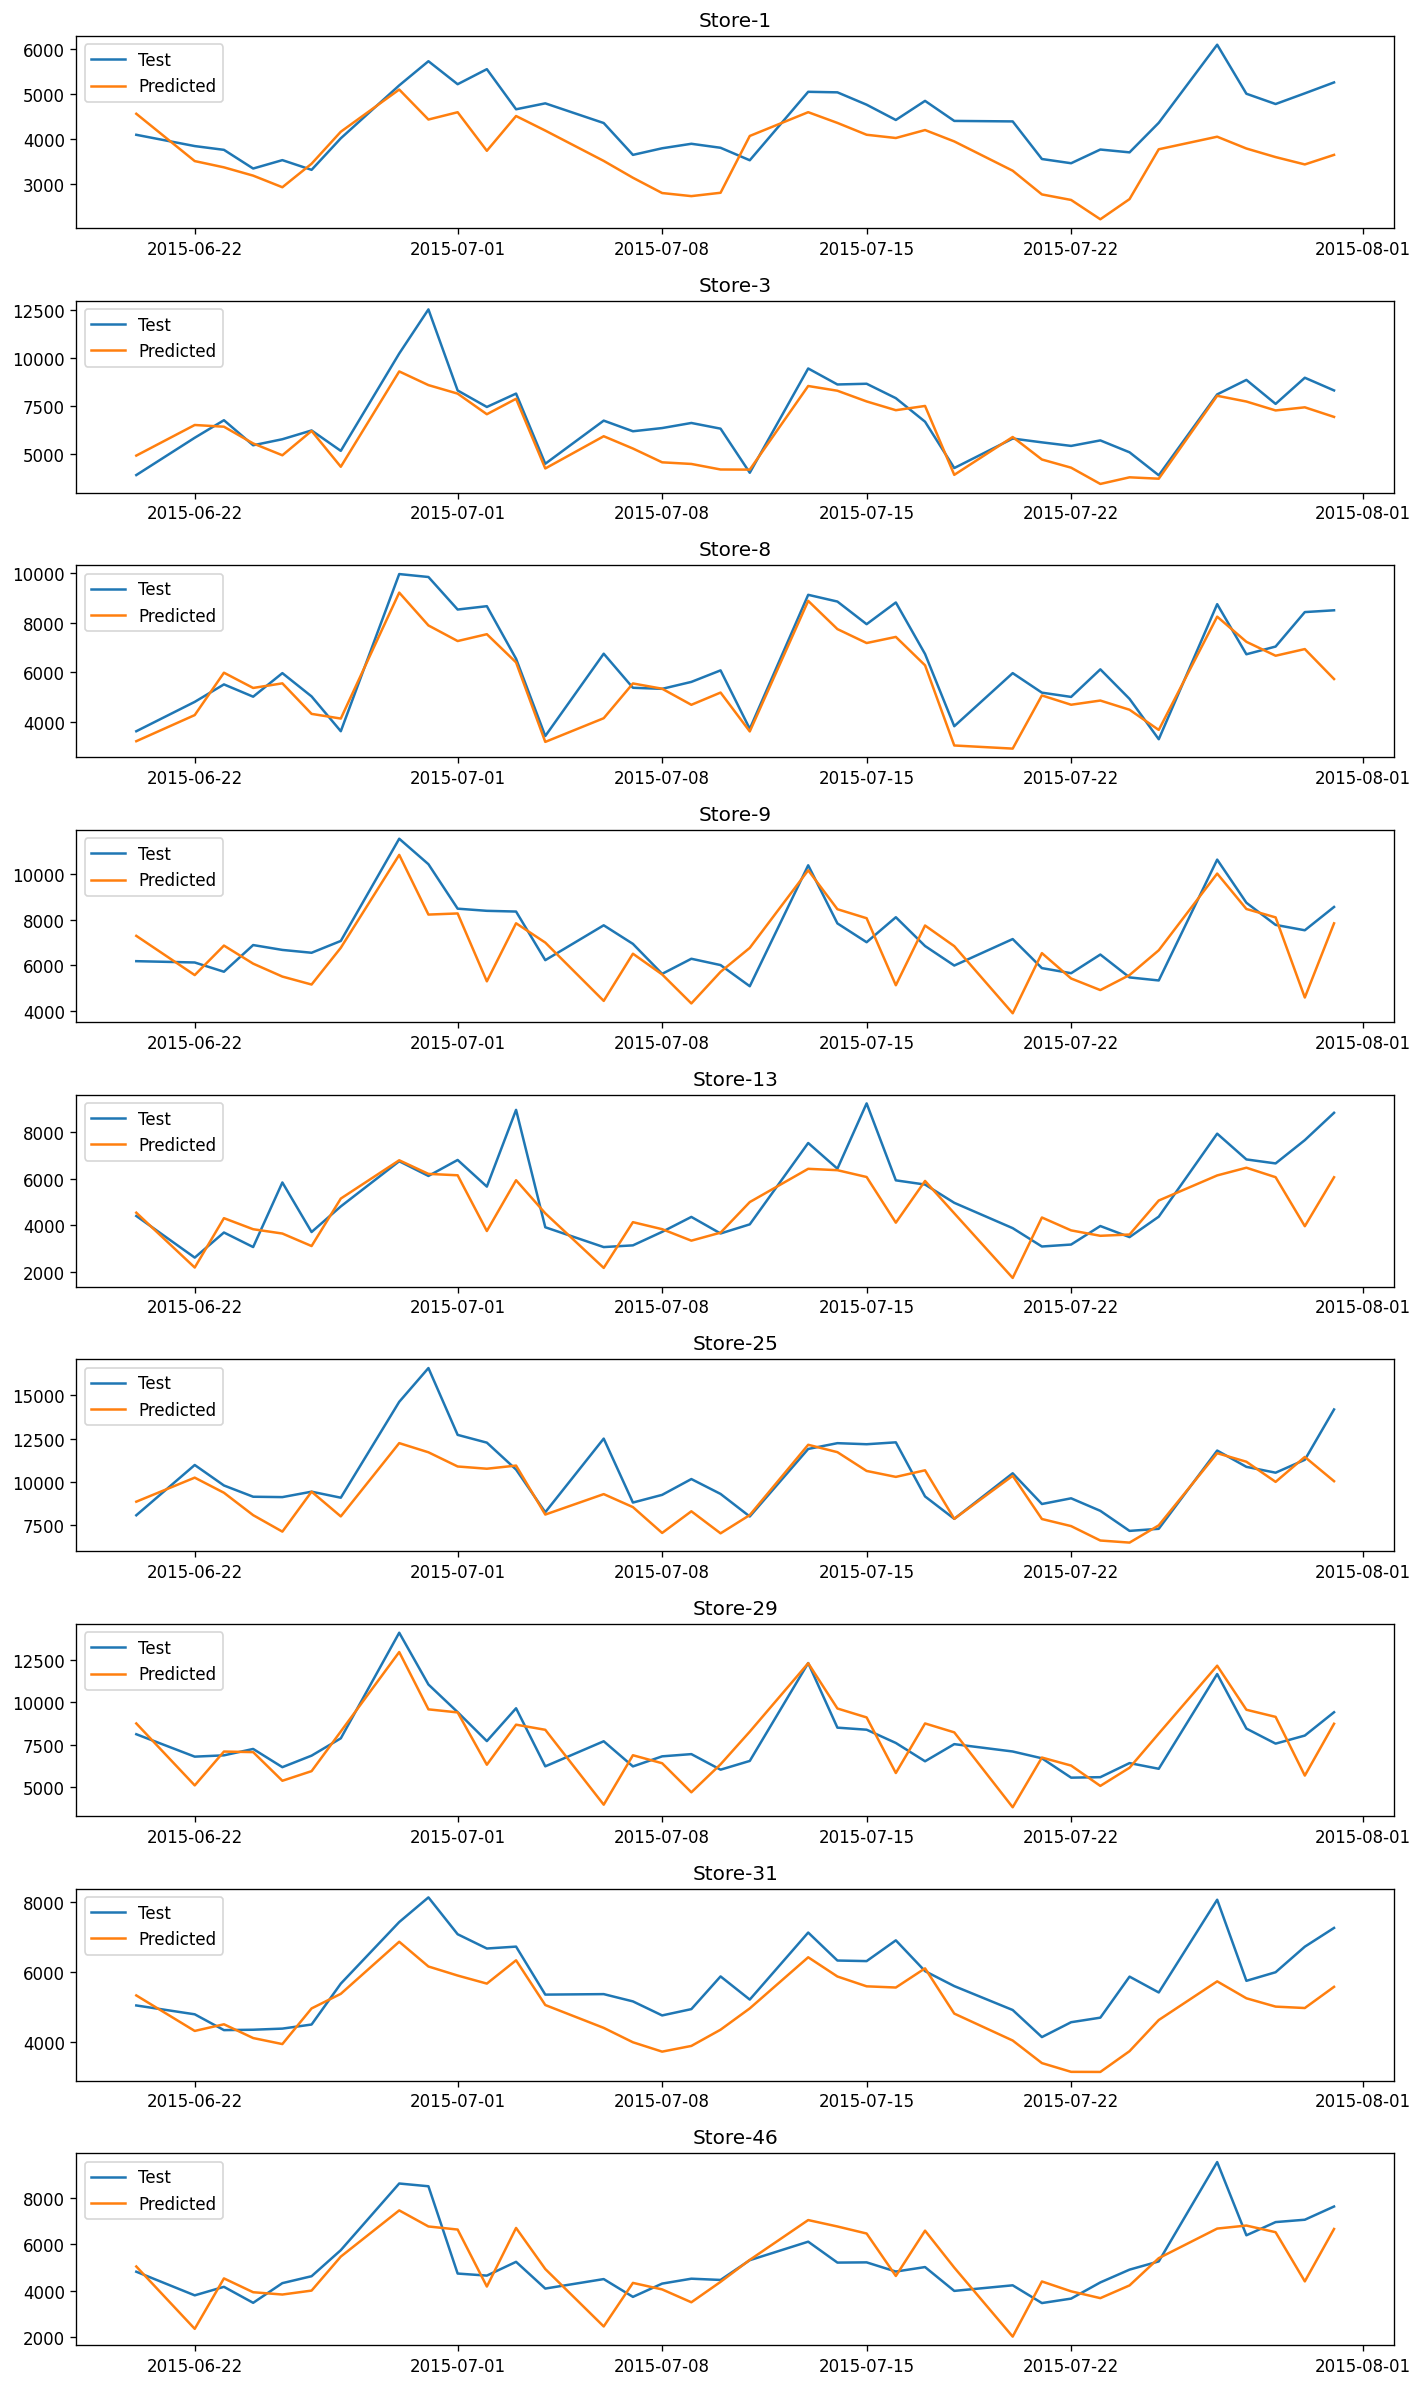

In [45]:
%%time
endogVarname = 'Sales'
exogVars = ['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5',
            'DayOfWeek_6']

fig, axes = plt.subplots(nrows=len_stores, ncols=1, dpi=120, figsize=(12,20))

for i, storeId in enumerate(list_stores):
    model_sarimax_2 = sm.tsa.statespace.SARIMAX(train_data[i][endogVarname], order=(mod_p, mod_d, mod_q), 
                                      seasonal_order=(mod_P, mod_D, mod_Q, mod_m),
                                     exog=train_data[i][train_data[i].columns.intersection(exogVars)])
    model_sarimax_fit_2 = model_sarimax_2.fit()
    
    y_pred = li_df_storeWiseData[i]
    
    min_sale_val, max_sale_val = normalizingDict_sales.get(storeId)
    
    y_pred['prediction'] = model_sarimax_fit_2.predict(y_pred.index.min(), y_pred.index.max(),
                                            exog=test_data[i][test_data[i].columns.intersection(exogVars)])
    
    
    # de-normalize these sales columns for evaluation
    sales_actual = denormalize(test_data[i][endogVarname], min_sale_val, max_sale_val)
    sales_predicted_sarimax_2 = denormalize(y_pred['prediction'][test_data[i].index.min():], min_sale_val, max_sale_val)
    
    # plot
    axes[i].plot(sales_actual, label='Test')
    axes[i].plot(sales_predicted_sarimax_2, label='Predicted')
    axes[i].legend(loc='upper left')
    ptitle = f"Store-{storeId}"
    axes[i].set_title(ptitle)
    
    sarimax_rmse, sarimax_mape = rmse_mape(sales_actual, sales_predicted_sarimax_2)
    summary_df = summary_df.append({'Model': 'SARIMAX w/o Customers',
                                    'Store': storeId,
                                    'RMSE': sarimax_rmse,
                                    'MAPE': sarimax_mape}, ignore_index=True)
    
plt.tight_layout()

In [46]:
summary_df[summary_df['Model'] == 'SARIMAX w/o Customers']

Model Store     RMSE   MAPE
41  SARIMAX w/o Customers     1   938.78  17.87
42  SARIMAX w/o Customers     3  1195.23  13.07
43  SARIMAX w/o Customers     8  1106.22  12.52
44  SARIMAX w/o Customers     9  1474.66  15.81
45  SARIMAX w/o Customers    13  1401.62  18.96
46  SARIMAX w/o Customers    25  1665.50  10.88
47  SARIMAX w/o Customers    29  1441.02  15.36
48  SARIMAX w/o Customers    31  1076.77  15.51
49  SARIMAX w/o Customers    46  1198.58  18.40

### VAR Model

#### Check for cointegration

In [47]:
%%time
for i, storeId in enumerate(list_stores):
    coint_test = li_df_storeWiseData[i][['Sales','Customers']]
    print(f"\nStore-{storeId}")
    ret = checkCointegration(li_df_storeWiseData[i]['Sales'], li_df_storeWiseData[i]['Customers'])
    print(f'Sales and Customers are {ret}')


Store-1
Sales and Customers are Cointegrated

Store-3
Sales and Customers are Cointegrated

Store-8
Sales and Customers are Cointegrated

Store-9
Sales and Customers are Cointegrated

Store-13
Sales and Customers are Cointegrated

Store-25
Sales and Customers are Cointegrated

Store-29
Sales and Customers are Cointegrated

Store-31
Sales and Customers are Cointegrated

Store-46
Sales and Customers are Cointegrated
Wall time: 375 ms


#### Insight
`Sales` and `Customers` are cointegrated for all the stores, hence we can use VAR models

Wall time: 27min 34s


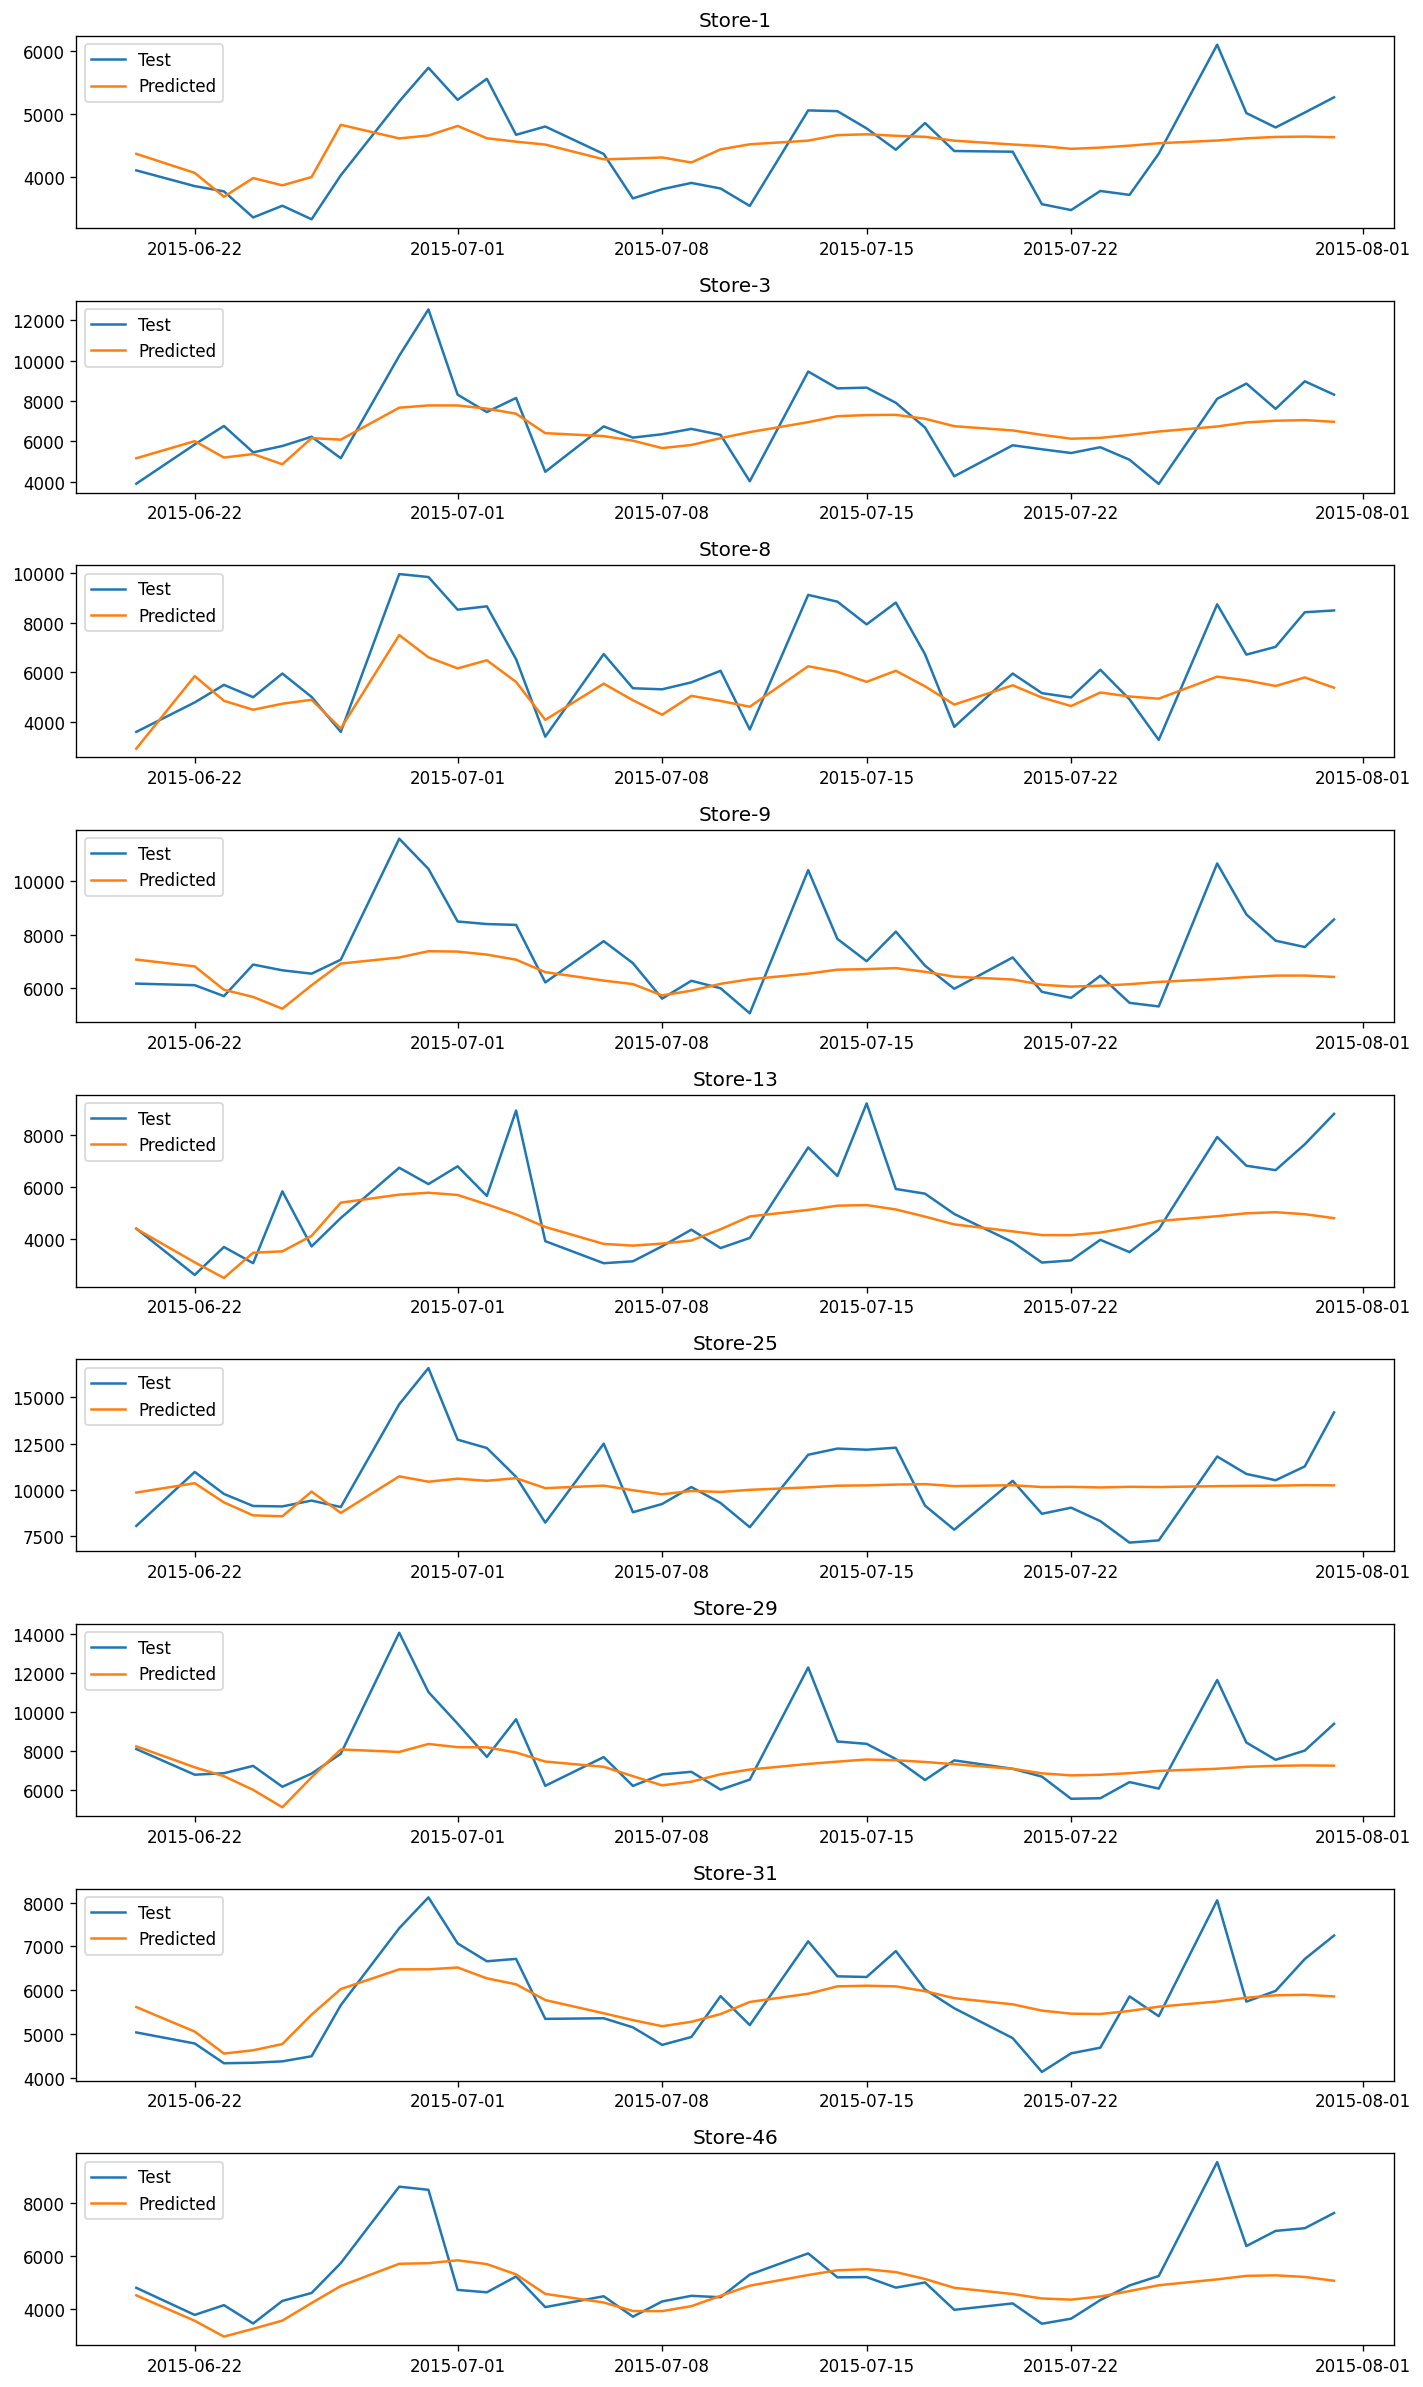

In [48]:
%%time
endogVars = ['Sales','Customers']

fig, axes = plt.subplots(nrows=len_stores, ncols=1, dpi=120, figsize=(12,20))

for i, storeId in enumerate(list_stores):
    model_var = sm.tsa.VARMAX(train_data[i][train_data[i].columns.intersection(endogVars)], 
                          order=(mod_p, mod_d, mod_q))
    
    model_var_fit = model_var.fit()
    
    y_pred = li_df_storeWiseData[i]
    
    min_sale_val, max_sale_val = normalizingDict_sales.get(storeId)
    
    y_pred = model_var_fit.predict(y_pred.index.min(), y_pred.index.max())
    
    
    # de-normalize these sales columns for evaluation
    sales_actual = denormalize(test_data[i][endogVars[0]], min_sale_val, max_sale_val)
    sales_predicted_var = denormalize(y_pred[endogVars[0]][test_data[i].index.min():], min_sale_val, max_sale_val)
    
    # plot
    axes[i].plot(sales_actual, label='Test')
    axes[i].plot(sales_predicted_var, label='Predicted')
    axes[i].legend(loc='upper left')
    ptitle = f"Store-{storeId}"
    axes[i].set_title(ptitle)
    
    var_rmse, var_mape = rmse_mape(sales_actual, sales_predicted_var)
    summary_df = summary_df.append({'Model': 'VAR',
                                    'Store': storeId,
                                    'RMSE': var_rmse,
                                    'MAPE': var_mape}, ignore_index=True)

plt.tight_layout()

In [49]:
summary_df[summary_df['Model'] == 'VAR']

Model Store     RMSE   MAPE
36   VAR     1   602.67  11.67
37   VAR     3  1541.64  18.56
38   VAR     8  1675.13  20.11
39   VAR     9  1622.72  14.56
40   VAR    13  1626.72  20.67
50   VAR     1   602.67  11.67
51   VAR     3  1541.64  18.56
52   VAR     8  1675.13  20.11
53   VAR     9  1622.72  14.56
54   VAR    13  1626.72  20.67
55   VAR    25  2004.24  15.00
56   VAR    29  1782.17  12.84
57   VAR    31   772.26  10.19
58   VAR    46  1283.33  14.62

### Observations

- VAR model is performing decent but not better than SARIMAX or SARIMA by any means
- Next we try VARMAX model to see if we get any better results

### VARMAX Model

Before building a VARMAX model we need to check for stationarity of the endog as well as the exog variables

In [71]:
list_stores = [1, 3, 8, 9, 13, 25, 29, 31, 46] 
potential_exog_endog_vars = ['Customers','Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5',
                        'DayOfWeek_6']

for store in list_stores:
    for var in potential_endog_vars:
        var_series = data_final_new[data_final_new['Store']==store][var]
        adf_res = checkStationarity(var_series)
        print(f"Store Id: {store} - {var} series is {adf_res}")
    print('-'*50)

Store Id: 1 - Customers series is Stationary
Store Id: 1 - Promo series is Stationary
Store Id: 1 - SchoolHoliday series is Stationary
Store Id: 1 - DayOfWeek_2 series is Stationary
Store Id: 1 - DayOfWeek_3 series is Stationary
Store Id: 1 - DayOfWeek_4 series is Stationary
Store Id: 1 - DayOfWeek_5 series is Stationary
Store Id: 1 - DayOfWeek_6 series is Stationary
--------------------------------------------------
Store Id: 3 - Customers series is Stationary
Store Id: 3 - Promo series is Stationary
Store Id: 3 - SchoolHoliday series is Stationary
Store Id: 3 - DayOfWeek_2 series is Stationary
Store Id: 3 - DayOfWeek_3 series is Stationary
Store Id: 3 - DayOfWeek_4 series is Stationary
Store Id: 3 - DayOfWeek_5 series is Stationary
Store Id: 3 - DayOfWeek_6 series is Stationary
--------------------------------------------------
Store Id: 8 - Customers series is Stationary
Store Id: 8 - Promo series is Stationary
Store Id: 8 - SchoolHoliday series is Stationary
Store Id: 8 - DayOfWeek

C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\PythonEnv\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retva

Wall time: 48min 47s


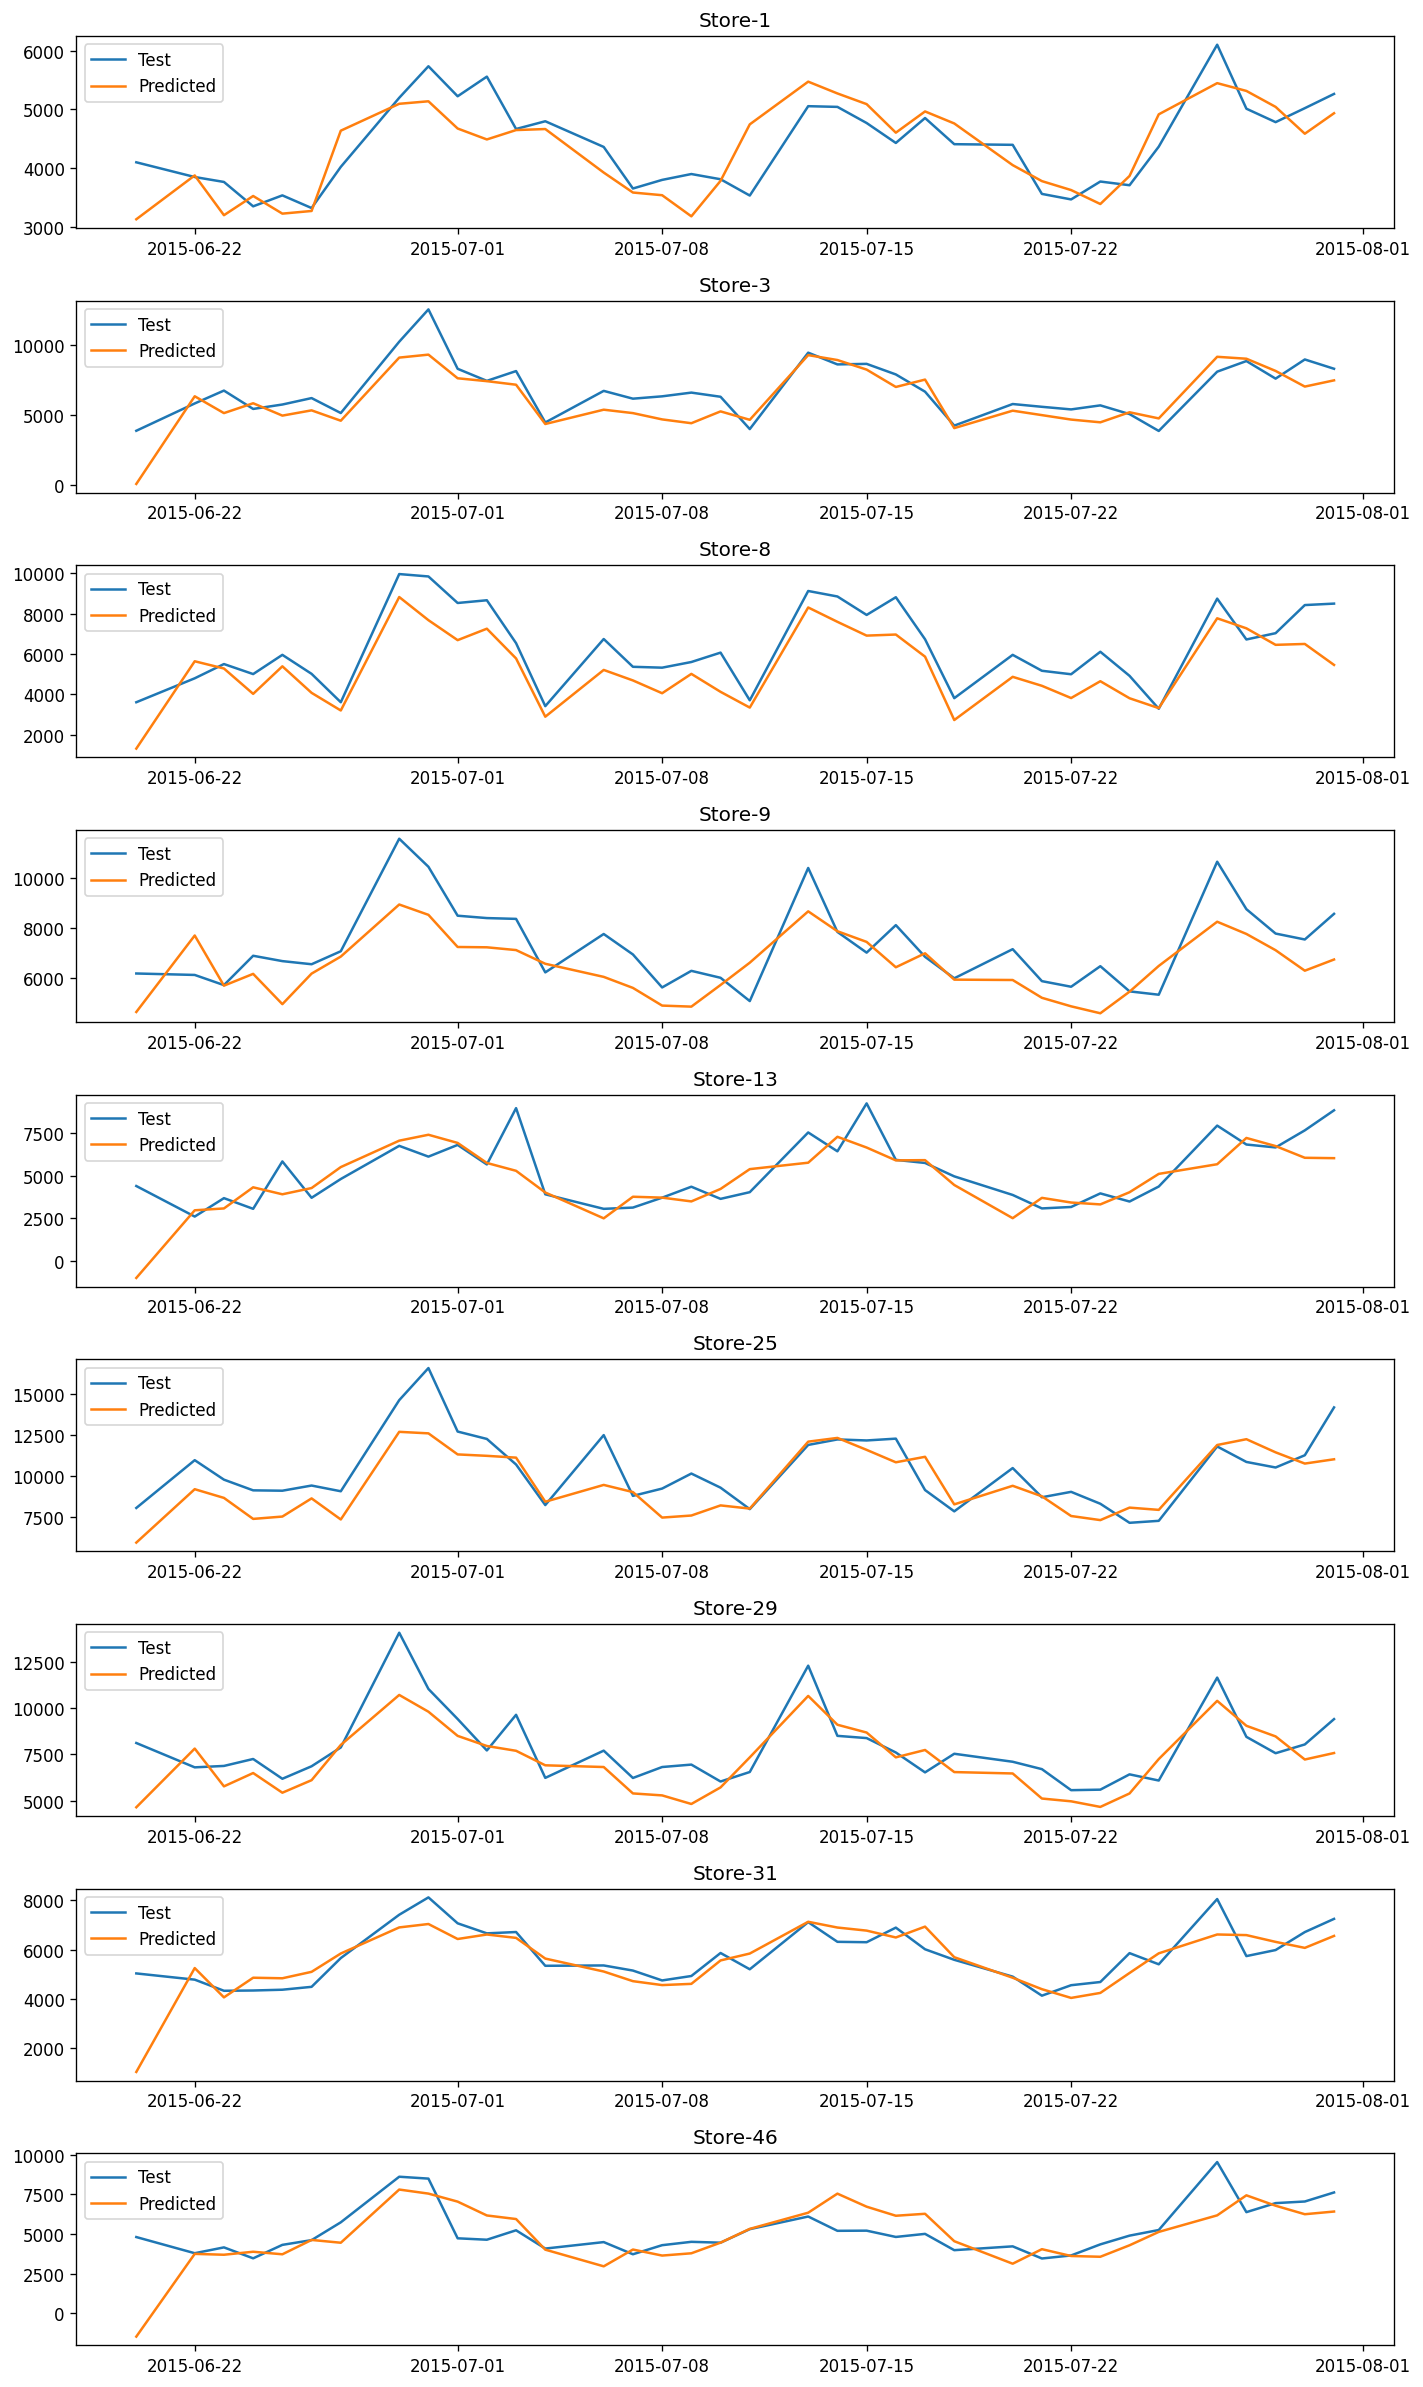

In [50]:
%%time
endogVars = ['Sales','Customers']
exogVars = ['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5',
            'DayOfWeek_6']

fig, axes = plt.subplots(nrows=len_stores, ncols=1, dpi=120, figsize=(12,20))

for i, storeId in enumerate(list_stores):
    model_varmax = sm.tsa.VARMAX(train_data[i][train_data[i].columns.intersection(endogVars)], 
                          order=(mod_p, mod_d, mod_q), 
                          seasonal_order=(mod_P, mod_D, mod_Q, mod_m),
                          exog=train_data[i][train_data[i].columns.intersection(exogVars)])
    
    model_varmax_fit = model_varmax.fit()
    
    y_pred = li_df_storeWiseData[i]
    
    min_sale_val, max_sale_val = normalizingDict_sales.get(storeId)
    
    y_pred = model_varmax_fit.predict(y_pred.index.min(), y_pred.index.max(),
                                            exog=test_data[i][test_data[i].columns.intersection(exogVars)])
    
    
    # de-normalize these sales columns for evaluation
    sales_actual = denormalize(test_data[i][endogVars[0]], min_sale_val, max_sale_val)
    sales_predicted_varmax = denormalize(y_pred[endogVars[0]][test_data[i].index.min():], min_sale_val, max_sale_val)
    
    # plot
    axes[i].plot(sales_actual, label='Test')
    axes[i].plot(sales_predicted_varmax, label='Predicted')
    axes[i].legend(loc='upper left')
    ptitle = f"Store-{storeId}"
    axes[i].set_title(ptitle)
    
    varmax_rmse, varmax_mape = rmse_mape(sales_actual, sales_predicted_varmax)
    summary_df = summary_df.append({'Model': 'VARMAX',
                                    'Store': storeId,
                                    'RMSE': varmax_rmse,
                                    'MAPE': varmax_mape}, ignore_index=True)

plt.tight_layout()

In [51]:
summary_df[summary_df['Model'] == 'VARMAX']

Model Store     RMSE   MAPE
59  VARMAX     1   469.25   8.47
60  VARMAX     3  1238.21  14.86
61  VARMAX     8  1277.61  17.82
62  VARMAX     9  1281.06  14.41
63  VARMAX    13  1531.09  19.88
64  VARMAX    25  1543.49  11.64
65  VARMAX    29  1315.87  13.84
66  VARMAX    31   863.46  10.06
67  VARMAX    46  1525.36  19.05

### Observations

- VARMAX model is performing much better than VAR
- Let us now try to see what the avg level of RMSE and MAPE are for all the stores for each category of model

In [58]:
summary_df[summary_df['Model']=='VAR']

Model Store     RMSE   MAPE
36   VAR     1   602.67  11.67
37   VAR     3  1541.64  18.56
38   VAR     8  1675.13  20.11
39   VAR     9  1622.72  14.56
40   VAR    13  1626.72  20.67
50   VAR     1   602.67  11.67
51   VAR     3  1541.64  18.56
52   VAR     8  1675.13  20.11
53   VAR     9  1622.72  14.56
54   VAR    13  1626.72  20.67
55   VAR    25  2004.24  15.00
56   VAR    29  1782.17  12.84
57   VAR    31   772.26  10.19
58   VAR    46  1283.33  14.62

In [66]:
mean_summary_df = summary_df.groupby(['Model']).mean()
mean_summary_df

RMSE       MAPE
Model                                        
ARIMA                  1571.348889  17.734444
SARIMA                 1278.977778  14.654444
SARIMAX                 459.346667   4.932222
SARIMAX w/o Customers  1277.597778  15.375556
VAR                    1434.542222  15.357778
VARMAX                 1227.266667  14.447778
XGBoost                 618.333333   6.906667

#### As we can see from our final summary table, the mean MAPE score across all stores in observed with our SARIMAX model

In [53]:
end_time = datetime.now()

print(f'Start time: {start_time}')
print(f'End time: {end_time}')

Start time: 2021-11-15 08:21:20.106159
End time: 2021-11-15 10:46:02.333571
